# Forth iteration model-Undersampling
Objetivo.Conocer los datos iniciales más relevantes del modelo random forest utilizado en el scoring anterior.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import seaborn as sns
#from seaborn import lmplot 
from seaborn import kdeplot 
'''need to install first folium :conda install -c conda-forge folium'''
import folium  
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.tree.export import export_text
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score

# from sklearn.metrics import mean_squared_error
# # from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
# #from xgboost.sklearn import XGBRegressor
from sklearn import tree


# librerias que voy a probar

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


%matplotlib inline


C:\Users\N58645\anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import sys


# Data preparation

### a. Download the data

In [2]:
# I downloaded the info from SAS. 
# I chuncksized it to upload it. For future iterations i ll try to get it directly from SAS

# For automation purpose i am going to look for the files path

pd.set_option('display.max_columns',50)

mother_file_path = os.path.abspath("TABLON_INICIAL.CSV")
mother_file = pd.read_csv(mother_file_path,sep=';',chunksize =200000,low_memory=False)

# i read the file 

file = mother_file
''' call the file outside the loop'''
all_chunks =pd.DataFrame()

for i,chunk in enumerate(file):
    print(i,len(all_chunks))
    all_chunks = all_chunks.append(chunk)
    all_chunks.drop_duplicates(inplace =True)

# I record it

all_chunks.to_csv('Total_clients_ini.csv',sep= ';',index =False)


Total_clients_ini= pd.read_csv('Total_clients_ini.csv',sep=';',squeeze=True)

# filter non residents to avoid noise. 

total_clients_file_ini = Total_clients_ini[(Total_clients_ini['pais_resi']== 'ES') &
                                           (Total_clients_ini['codseg']!= 'BC')]

total_clients_file_ini.shape

0 0


C:\Users\N58645\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,76,81,83,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(197967, 95)

In [3]:
total_clients_file_ini.sample(5)

,tipopers,codpers,score,sexo,edad,pais_naci,pais_resi,nivestud,idiomapr,tiptraba,oficin,tipo_est,codseg,cpper,cprovper,clocaper,autonper,cpaisper,codine,poblac_cmun,rentadisp_cmun,num_tarj_credito_0m,imp_med_tarj_credito_0m,num_cuentas_0m,imp_med_cuentas_0m,...,imp_nompenr_3t4t_delta,num_tac_3t4t_delta,num_tar_3t4t_delta,transferencias_habitual_3t4t_delta,app_par_3t4t_delta,transferencias_inmediata_3t4t_delta,acc_noc_3t4t_delta,transferencias_traspaso_3t4t_delta,prestamos_contratacion_prestamo_preconcedido_3t4t_delta,transferencias_3t4t_delta,tarjetas_consulta_pin_3t4t_delta,tablet_3t4t_delta,recibos_3t4t_delta,pc_3t4t_delta,tarjetas_dinero_directo_3t4t_delta,acc_tar_3t4t_delta,transferencias_alta_transferencia_periodica_nacional_0m,transferencias_modificacion_transferencia_programada_4tri,prestamos_contratacion_prestamo_preconcedido_3tri,nominas_0m,remesas_envio_directo_3t4t_delta,transferencias_alta_transferencia_periodica_nacional_3t4t_delta,imp_med_cuenta_123_zero_3t4t_delta,imp_med_cuenta_123_3t4t_delta,contrata_consumo
148833,F,36674658,"0,211199747",V,38,ES,ES,3,E,P,6021.0,S,CN,2004,2,90008,8,ES,2003.0,172816,21088,0,0,1,0,...,259.01,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0
81594,F,14718996,"0,128680818",H,60,ES,ES,5,E,O,255.0,V,PR,35509,35,306,5,ES,35024.0,21896,20909,0,0,1,"443,59",...,0.00,-3.0,-3.0,-2.0,39.0,0.0,0.13333333333333333,0.0,0.0,-2.0,0.0,0,0.0,-0.0526316,0.0,-0.20964912280701756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.19,0
188256,F,49666679,"0,043189656",V,88,ES,ES,3,E,J,7195.0,N,PI,41014,41,301,1,ES,41091.0,689434,22822,0,0,1,"341824,28",...,0.00,0.0,0.0,0.0,-25.0,0.0,-0.222222,1.0,0.0,1.0,-3.0,0.0,0.0,0,0.0,-0.0042735042735042575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,981.28,0
157922,F,38739745,"0,151442908",H,61,RO,ES,3,E,A,297.0,S,PR,46134,46,215,10,ES,46126.0,7234,20008,0,0,1,"341,97",...,-1438.81,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,736.16,0
59576,F,10096476,"0,038332287",V,89,ES,ES,5,E,J,5964.0,C,PR,2003,2,90008,8,ES,2003.0,172816,21088,0,0,1,"77146,44",...,-16754.68,0.0,69.0,0.0,-5.0,0.0,0.0245098,1.0,0.0,-3.0,6.0,0,0.0,0,0.0,-0.0931372549019608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2479.81,0


In [4]:
# change order to have the dependent feature first
newdf = total_clients_file_ini[total_clients_file_ini.columns[0:-1]]
newdf_contrata = total_clients_file_ini[total_clients_file_ini.columns[-1:]]
total_clients_file_ini = pd.concat([newdf_contrata, newdf], axis = 1)
total_clients_file_ini

,contrata_consumo,tipopers,codpers,score,sexo,edad,pais_naci,pais_resi,nivestud,idiomapr,tiptraba,oficin,tipo_est,codseg,cpper,cprovper,clocaper,autonper,cpaisper,codine,poblac_cmun,rentadisp_cmun,num_tarj_credito_0m,imp_med_tarj_credito_0m,num_cuentas_0m,...,num_nompene_3t4t_delta,imp_nompenr_3t4t_delta,num_tac_3t4t_delta,num_tar_3t4t_delta,transferencias_habitual_3t4t_delta,app_par_3t4t_delta,transferencias_inmediata_3t4t_delta,acc_noc_3t4t_delta,transferencias_traspaso_3t4t_delta,prestamos_contratacion_prestamo_preconcedido_3t4t_delta,transferencias_3t4t_delta,tarjetas_consulta_pin_3t4t_delta,tablet_3t4t_delta,recibos_3t4t_delta,pc_3t4t_delta,tarjetas_dinero_directo_3t4t_delta,acc_tar_3t4t_delta,transferencias_alta_transferencia_periodica_nacional_0m,transferencias_modificacion_transferencia_programada_4tri,prestamos_contratacion_prestamo_preconcedido_3tri,nominas_0m,remesas_envio_directo_3t4t_delta,transferencias_alta_transferencia_periodica_nacional_3t4t_delta,imp_med_cuenta_123_zero_3t4t_delta,imp_med_cuenta_123_3t4t_delta
0,0,F,1957,"0,020162208",H,78,ES,ES,3,E,J,5321.0,C,PR,38006,38,419,5,ES,38038.0,203692,22339,1,"-88,21",1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0,F,2807,"0,035442999",V,87,ES,ES,5,E,O,5402.0,V,PB,39527,39,888,6,ES,39068.0,0,0,0,0,2,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,0,F,2917,"0,081880022",V,81,ES,ES,3,E,J,5230.0,C,PR,32910,32,2327,12,ES,32075.0,5184,17802,0,0,2,...,0.0,606.10,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.00
3,0,F,3537,"0,118240142",V,78,ES,ES,5,E,J,5021.0,B,PR,33590,33,90785,3,ES,33055.0,1753,15894,0,0,1,...,0.0,334.65,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2471.87
5,0,F,7224,"0,344147113",V,70,SE,ES,5,E,J,1482.0,C,PI,28703,28,490,13,ES,28134.0,86707,26447,2,"135,05",1,...,0.0,0.00,1.0,-32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1364.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,0,F,51799547,"0,055731176",V,19,ES,ES,2,E,O,NaN,S,PR,50001,50,0,2,ES,50297.0,664938,22358,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
199993,0,F,51804017,"0,134726513",V,21,ES,ES,6,E,O,NaN,S,PR,14720,14,0,1,ES,14005.0,7982,13948,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
199994,0,F,51804815,"0,206613677",H,22,ES,ES,1,E,A,NaN,S,PR,46900,46,0,10,ES,46244.0,80630,19906,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
199996,0,F,51810895,"0,071539903",V,25,ES,ES,5,E,O,NaN,S,PR,28053,28,0,13,ES,28079.0,3182981,29400,0,0,1,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00


In [5]:
print('Total clientes with loan: ',total_clients_file_ini[total_clients_file_ini.contrata_consumo ==1].shape)
print('Total clientes without loan: ', total_clients_file_ini[total_clients_file_ini.contrata_consumo ==0].shape)

Total clientes with loan:  (3600, 95)
Total clientes without loan:  (194367, 95)


In [6]:
# Some variables are no going to be relevant for this study so i am going to drop them

total_clients_file_ini.drop(['oficin','codine','pais_naci', 'pais_resi','idiomapr','cpaisper',
                                                     'tipopers','codpers','score','tipo_est'], axis=1,inplace =True)



In [7]:
total_clients_file_ini.columns

Index(['contrata_consumo', 'sexo', 'edad', 'nivestud', 'tiptraba', 'codseg',
       'cpper', 'cprovper', 'clocaper', 'autonper', 'poblac_cmun',
       'rentadisp_cmun', 'num_tarj_credito_0m', 'imp_med_tarj_credito_0m',
       'num_cuentas_0m', 'imp_med_cuentas_0m', 'num_fondos_0m',
       'imp_med_fondos_0m', 'H2496_INDHIPOT', 'num_valores_0m',
       'imp_med_valores_0m', 'acc_0m', 'movil_0m', 'pc_0m', 'tablet_0m',
       'transferencias_nacional_0m', 'transferencias_traspaso_0m',
       'app_par_0m', 'web_par_0m', 'imp_trfe_0m', 'imp_trfr_0m',
       'imp_nompenr_0m', 'imp_rec_0m', 'imp_tar_0m', 'num_trfr_0m',
       'num_trfe_0m', 'num_rec_0m', 'imp_med_fondos_mixtos_3t4t_delta',
       'imp_med_fondos_conserv_3t4t_delta', 'imp_med_tarj_debito_3t4t_delta',
       'imp_med_cuenta_estandar_3t4t_delta', 'num_cuenta_dad_pf_3t4t_delta',
       'num_fondos_mixtos_3t4t_delta', 'imp_med_fondos_arriesg_3t4t_delta',
       'num_tarj_debito_3t4t_delta', 'num_tarj_pago_aplazado_3t4t_delta',
   

In [8]:
# check the type .
total_clients_file_ini.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197967 entries, 0 to 199997
Data columns (total 85 columns):
contrata_consumo                                                   197967 non-null int64
sexo                                                               197967 non-null object
edad                                                               197967 non-null int64
nivestud                                                           197967 non-null int64
tiptraba                                                           197967 non-null object
codseg                                                             197967 non-null object
cpper                                                              197947 non-null object
cprovper                                                           197933 non-null object
clocaper                                                           197967 non-null int64
autonper                                                           197933 non-null 

In [9]:
total_clients_file_ini.isnull().sum()

contrata_consumo                                                       0
sexo                                                                   0
edad                                                                   0
nivestud                                                               0
tiptraba                                                               0
                                                                   ...  
nominas_0m                                                         56332
remesas_envio_directo_3t4t_delta                                   56332
transferencias_alta_transferencia_periodica_nacional_3t4t_delta    56332
imp_med_cuenta_123_zero_3t4t_delta                                   505
imp_med_cuenta_123_3t4t_delta                                        505
Length: 85, dtype: int64

In [10]:
# check for duplicates.

duplicateRowsDF = total_clients_file_ini[total_clients_file_ini.duplicated()]
 
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF)


Duplicate Rows except first occurrence based on all columns are :
Empty DataFrame
Columns: [contrata_consumo, sexo, edad, nivestud, tiptraba, codseg, cpper, cprovper, clocaper, autonper, poblac_cmun, rentadisp_cmun, num_tarj_credito_0m, imp_med_tarj_credito_0m, num_cuentas_0m, imp_med_cuentas_0m, num_fondos_0m, imp_med_fondos_0m, H2496_INDHIPOT, num_valores_0m, imp_med_valores_0m, acc_0m, movil_0m, pc_0m, tablet_0m, transferencias_nacional_0m, transferencias_traspaso_0m, app_par_0m, web_par_0m, imp_trfe_0m, imp_trfr_0m, imp_nompenr_0m, imp_rec_0m, imp_tar_0m, num_trfr_0m, num_trfe_0m, num_rec_0m, imp_med_fondos_mixtos_3t4t_delta, imp_med_fondos_conserv_3t4t_delta, imp_med_tarj_debito_3t4t_delta, imp_med_cuenta_estandar_3t4t_delta, num_cuenta_dad_pf_3t4t_delta, num_fondos_mixtos_3t4t_delta, imp_med_fondos_arriesg_3t4t_delta, num_tarj_debito_3t4t_delta, num_tarj_pago_aplazado_3t4t_delta, imp_med_tarj_pago_aplazado_3t4t_delta, num_depositos_3t4t_delta, num_tarj_credito_3t4t_delta, imp_med

### b. Categorical features preparation 

In [11]:
# Treat different data type cols differently. Only 3 real categorical cols.I select them and drop them from original file
# Convert score col into categorical
# fillna with forward fill

colsToDrop = ['edad',  
       'cpper', 'cprovper', 'clocaper', 'autonper', 'poblac_cmun',
       'rentadisp_cmun', 'num_tarj_credito_0m', 'imp_med_tarj_credito_0m',
       'num_cuentas_0m', 'imp_med_cuentas_0m', 'num_fondos_0m',
       'imp_med_fondos_0m', 'num_valores_0m',
       'imp_med_valores_0m', 'acc_0m', 'movil_0m', 'pc_0m', 'tablet_0m',
       'transferencias_nacional_0m', 'transferencias_traspaso_0m',
       'app_par_0m', 'web_par_0m', 'imp_trfe_0m', 'imp_trfr_0m',
       'imp_nompenr_0m', 'imp_rec_0m', 'imp_tar_0m', 'num_trfr_0m',
       'num_trfe_0m', 'num_rec_0m','contrata_consumo']
categorical_file = total_clients_file_ini.drop(colsToDrop, axis=1)
categorical_file['H2496_INDHIPOT'].fillna('N', inplace = True)
categorical_file.sample(5)

,sexo,nivestud,tiptraba,codseg,H2496_INDHIPOT,imp_med_fondos_mixtos_3t4t_delta,imp_med_fondos_conserv_3t4t_delta,imp_med_tarj_debito_3t4t_delta,imp_med_cuenta_estandar_3t4t_delta,num_cuenta_dad_pf_3t4t_delta,num_fondos_mixtos_3t4t_delta,imp_med_fondos_arriesg_3t4t_delta,num_tarj_debito_3t4t_delta,num_tarj_pago_aplazado_3t4t_delta,imp_med_tarj_pago_aplazado_3t4t_delta,num_depositos_3t4t_delta,num_tarj_credito_3t4t_delta,imp_med_renting_3t4t_delta,num_cuenta_123_3t4t_delta,num_cuentas_3t4t_delta,imp_med_tarj_pago_facil_3t4t_delta,imp_med_tarj_credito_3t4t_delta,num_tarj_revolving_3t4t_delta,imp_med_valores_3t4t_delta,imp_tac_3t4t_delta,...,num_nompene_3t4t_delta,imp_nompenr_3t4t_delta,num_tac_3t4t_delta,num_tar_3t4t_delta,transferencias_habitual_3t4t_delta,app_par_3t4t_delta,transferencias_inmediata_3t4t_delta,acc_noc_3t4t_delta,transferencias_traspaso_3t4t_delta,prestamos_contratacion_prestamo_preconcedido_3t4t_delta,transferencias_3t4t_delta,tarjetas_consulta_pin_3t4t_delta,tablet_3t4t_delta,recibos_3t4t_delta,pc_3t4t_delta,tarjetas_dinero_directo_3t4t_delta,acc_tar_3t4t_delta,transferencias_alta_transferencia_periodica_nacional_0m,transferencias_modificacion_transferencia_programada_4tri,prestamos_contratacion_prestamo_preconcedido_3tri,nominas_0m,remesas_envio_directo_3t4t_delta,transferencias_alta_transferencia_periodica_nacional_3t4t_delta,imp_med_cuenta_123_zero_3t4t_delta,imp_med_cuenta_123_3t4t_delta
45754,H,5,A,CN,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,224.81,0.0,-1.21,1035.55,...,0.0,-1355.81,18.0,18.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.7,0.0,-0.2,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5376.1
91981,V,2,A,PR,S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.0,0.00,0.0,17.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
189352,H,2,O,PR,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.0,0.00,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116932,V,2,P,CN,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.0,0.00,0.0,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
177156,H,3,J,PI,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
categorical_file.shape

(197967, 53)

In [13]:
categorical_file['nivestud'] = categorical_file['nivestud'].astype('O')

In [14]:
# #change all categorical variables into dummies for the model

categorical_file_mod= pd.get_dummies(categorical_file[['sexo','nivestud','tiptraba','codseg','H2496_INDHIPOT']])
categorical_file_mod
# train_df = pd.concat([numeric_features, color_features], axis=1)
# train_df.head(3)

,sexo_H,sexo_V,nivestud_1,nivestud_2,nivestud_3,nivestud_4,nivestud_5,nivestud_6,tiptraba_A,tiptraba_J,tiptraba_O,tiptraba_P,codseg_CN,codseg_PB,codseg_PI,codseg_PR,H2496_INDHIPOT_N,H2496_INDHIPOT_S
0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
2,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
3,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0
5,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
199993,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
199994,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
199996,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0


In [15]:
categorical_file_final_mod = pd.concat([total_clients_file_ini.contrata_consumo.to_frame(),categorical_file_mod],axis=1, sort=False)
categorical_file_final_mod

,contrata_consumo,sexo_H,sexo_V,nivestud_1,nivestud_2,nivestud_3,nivestud_4,nivestud_5,nivestud_6,tiptraba_A,tiptraba_J,tiptraba_O,tiptraba_P,codseg_CN,codseg_PB,codseg_PI,codseg_PR,H2496_INDHIPOT_N,H2496_INDHIPOT_S
0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
3,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0
5,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
199993,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
199994,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
199996,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0


### c. Numerical features preparation

In [16]:
usecols = ['edad', 
       'cpper', 'cprovper', 'clocaper', 'autonper', 'poblac_cmun',
       'rentadisp_cmun', 'num_tarj_credito_0m', 'imp_med_tarj_credito_0m',
       'num_cuentas_0m', 'imp_med_cuentas_0m', 'num_fondos_0m',
       'imp_med_fondos_0m', 'num_valores_0m',
       'imp_med_valores_0m', 'acc_0m', 'movil_0m', 'pc_0m', 'tablet_0m',
       'transferencias_nacional_0m', 'transferencias_traspaso_0m',
       'app_par_0m', 'web_par_0m', 'imp_trfe_0m', 'imp_trfr_0m',
       'imp_nompenr_0m', 'imp_rec_0m', 'imp_tar_0m', 'num_trfr_0m',
       'num_trfe_0m', 'num_rec_0m']

numerical_file = pd.DataFrame(total_clients_file_ini, columns = usecols)
numerical_file.sample(5)

,edad,cpper,cprovper,clocaper,autonper,poblac_cmun,rentadisp_cmun,num_tarj_credito_0m,imp_med_tarj_credito_0m,num_cuentas_0m,imp_med_cuentas_0m,num_fondos_0m,imp_med_fondos_0m,num_valores_0m,imp_med_valores_0m,acc_0m,movil_0m,pc_0m,tablet_0m,transferencias_nacional_0m,transferencias_traspaso_0m,app_par_0m,web_par_0m,imp_trfe_0m,imp_trfr_0m,imp_nompenr_0m,imp_rec_0m,imp_tar_0m,num_trfr_0m,num_trfe_0m,num_rec_0m
99260,36,********,**,0,**,0,0,3,"205,93",3,"165523,49",0,0,4,"28914,41",14,"0,714285714","0,285714286",0,1,0,10,4,"70218,2","69659,53",0,"784,32","562,76",3,4,10
176761,25,8401,8,538,9,60695,23236,0,0,1,"3115,85",0,0,0,0,8,1,0,0,0,0,8,0,77,"2173,97","2163,97",0,"513,45",3,3,0
85880,26,34002,34,228,7,78892,20960,0,0,2,"4117,96",0,0,1,"3,58",12,1,0,0,0,1,9,1,435,3301,2105,0,"640,76",6,3,0
112669,71,14200,14,371,1,11031,18419,2,"70,06",1,"17509,97",0,0,1,"3,58",0,0,0,0,0,0,0,0,0,"677,4","677,4","20,8","331,52",1,0,2
18814,55,24006,24,512,7,125317,22167,2,"450,79",1,"113495,26",0,0,3,"14544,76",11,"0,727272727","0,272727273",0,0,5,7,3,10,"3216,2","2482,2","218,02","4810,88",4,1,7


In [17]:
numerical_file.shape

(197967, 31)

In [18]:
# some columns have nan. Since there are not too many i am going to replace it for the previous value.

change_nan = ('cpper','cprovper','autonper')

for value in change_nan:
    numerical_file[value].fillna( '0', inplace = True) 

## decimal with commas by dots for all columns with 'imp' as part of the name

commas= numerical_file.loc[:,numerical_file.columns.str.contains("imp")]

for value in commas: 
    numerical_file.replace(',', '.',regex=True,inplace =True)
    numerical_file[value].to_frame()
    

## decimal with commas by dots  

commas2 = ['movil_0m','pc_0m','poblac_cmun','tablet_0m']

for values in commas2:
    numerical_file[values].replace(',', '.',regex=True,inplace =True)
    numerical_file[value].to_frame()

## transform wierd values from some columns (change to 0). Change commas by dots

numerical_file['cpper'].replace('********', value='11111',inplace=True)
numerical_file['cpper'].replace('39570POT', value='11111',inplace=True)
numerical_file['cpper'].replace('151 34', value='11111',inplace=True)
numerical_file['cprovper'].replace('**', value='00',inplace=True)
numerical_file['autonper'].replace('**', value='00',inplace=True)

numerical_file.sample(5)
# numerical_file.isna().sum()
# numerical_file.info()b

,edad,cpper,cprovper,clocaper,autonper,poblac_cmun,rentadisp_cmun,num_tarj_credito_0m,imp_med_tarj_credito_0m,num_cuentas_0m,imp_med_cuentas_0m,num_fondos_0m,imp_med_fondos_0m,num_valores_0m,imp_med_valores_0m,acc_0m,movil_0m,pc_0m,tablet_0m,transferencias_nacional_0m,transferencias_traspaso_0m,app_par_0m,web_par_0m,imp_trfe_0m,imp_trfr_0m,imp_nompenr_0m,imp_rec_0m,imp_tar_0m,num_trfr_0m,num_trfe_0m,num_rec_0m
149914,43,27850,27,9474,12,15550,18968,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150621,53,32130,32,3433,12,2241,13996,0,0,1,23.16,0,0,0,0,0,0,0,0,0,0,0,0,0,1314.31,1314.31,0,0,1,0,0
22294,77,8021,8,65,9,1620809,28514,2,177.97,1,19969.32,0,0,0,0,0,0,0,0,0,0,0,0,0,793.74,640.74,44.9,232.35,2,0,1
93634,40,3510,3,166,10,7223,15391,2,429.57,1,7773.96,0,0,1,3.58,2,1,0,0,0,0,2,0,835.81,3196.14,0,809.84,0,6,3,9
104990,56,41003,41,301,1,689434,22822,0,0,1,5713.46,0,0,0,0,6,1,0,0,4,0,6,0,605.45,0,0,305.56,1.21,0,4,1


In [19]:
numerical_file.shape

(197967, 31)

### d.Merge categ and numerical files

In [20]:
total_clients_mod = pd.concat([categorical_file_final_mod.contrata_consumo,numerical_file, categorical_file_mod],axis =1)
total_clients_mod.sample(5)

,contrata_consumo,edad,cpper,cprovper,clocaper,autonper,poblac_cmun,rentadisp_cmun,num_tarj_credito_0m,imp_med_tarj_credito_0m,num_cuentas_0m,imp_med_cuentas_0m,num_fondos_0m,imp_med_fondos_0m,num_valores_0m,imp_med_valores_0m,acc_0m,movil_0m,pc_0m,tablet_0m,transferencias_nacional_0m,transferencias_traspaso_0m,app_par_0m,web_par_0m,imp_trfe_0m,imp_trfr_0m,imp_nompenr_0m,imp_rec_0m,imp_tar_0m,num_trfr_0m,num_trfe_0m,num_rec_0m,sexo_H,sexo_V,nivestud_1,nivestud_2,nivestud_3,nivestud_4,nivestud_5,nivestud_6,tiptraba_A,tiptraba_J,tiptraba_O,tiptraba_P,codseg_CN,codseg_PB,codseg_PI,codseg_PR,H2496_INDHIPOT_N,H2496_INDHIPOT_S
58344,0,77,3570,3,90333,10,33607,18012,0,0,2,208470.91,0,0,1,307.01,0,0,0,0,0,0,0,0,0,666.44,420.2,189.45,0,2,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
19672,0,64,39710,39,1042,6,7459,19579,2,442.49,2,445469.43,1,67682.63,3,44551.64,6,0.5,0.5,0,0,0,3,3,87.5,1656.36,1656.36,1917.73,708.84,1,1,6,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
41503,0,79,28280,28,628,13,15562,25082,2,19.82,1,29125.35,0,0,1,3.58,5,1,0,0,0,0,5,0,0,2158.11,2158.11,249.46,330.88,1,0,5,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0
156740,0,27,41120,41,142,1,10051,23170,0,0,1,298.03,0,0,0,0,17,1,0,0,0,0,13,4,0,617.58,617.58,55.92,353.03,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0
154944,0,56,8042,8,65,9,1620809,28514,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1466.64,1386.64,433.88,0,2,0,4,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1


In [21]:
total_clients_mod.shape

(197967, 50)

In [22]:
# changing all columns types to numerics and downcasting it. 
columns = total_clients_mod.columns

file_name = total_clients_mod

for cols in columns:
    if file_name[cols].dtype == 'int64':
        file_name[cols] = pd.to_numeric(file_name[cols], downcast='unsigned')
    else:
        file_name[cols] = pd.to_numeric(file_name[cols], downcast='float')

total_clients_mod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197967 entries, 0 to 199997
Data columns (total 50 columns):
contrata_consumo              197967 non-null uint8
edad                          197967 non-null uint8
cpper                         197967 non-null float32
cprovper                      197967 non-null float32
clocaper                      197967 non-null uint32
autonper                      197967 non-null float32
poblac_cmun                   197967 non-null float32
rentadisp_cmun                197967 non-null uint16
num_tarj_credito_0m           197967 non-null uint8
imp_med_tarj_credito_0m       197967 non-null float32
num_cuentas_0m                197967 non-null uint8
imp_med_cuentas_0m            197967 non-null float32
num_fondos_0m                 197967 non-null uint8
imp_med_fondos_0m             197967 non-null float32
num_valores_0m                197967 non-null uint8
imp_med_valores_0m            197967 non-null float32
acc_0m                        197967 no

In [23]:
total_clients_mod.describe(include = 'all').T  # ask why i dont gwt freq

,count,mean,std,min,25%,50%,75%,max
contrata_consumo,197967.0,0.018185,0.133620,0.000000,0.000000,0.000000,0.000000,1.000000e+00
edad,197967.0,53.409689,16.793516,18.000000,41.000000,53.000000,66.000000,8.900000e+01
cpper,197967.0,26622.333984,13324.348633,0.000000,15004.000000,28049.000000,36691.000000,7.501500e+04
cprovper,197967.0,26.171261,13.506155,0.000000,15.000000,28.000000,36.000000,5.200000e+01
clocaper,197967.0,10020.656645,27571.958024,0.000000,130.000000,254.000000,618.000000,9.188000e+04
autonper,197967.0,8.351048,4.659194,0.000000,5.000000,9.000000,13.000000,1.900000e+01
poblac_cmun,197967.0,493462.937500,980188.250000,0.000000,13359.000000,68859.000000,292986.000000,3.182981e+06
rentadisp_cmun,197967.0,20857.719989,6570.301062,0.000000,17757.000000,20980.000000,23199.000000,5.342800e+04
num_tarj_credito_0m,197967.0,0.625968,0.950006,0.000000,0.000000,0.000000,2.000000,1.000000e+01
imp_med_tarj_credito_0m,197967.0,86.179466,407.848358,-12354.839844,0.000000,0.000000,2.300000,6.123477e+04


# Visualization 

### a.Categorical features visualization

In [24]:
categorical_file_ndum = categorical_file.copy() 
categorical_file_ndum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197967 entries, 0 to 199997
Data columns (total 53 columns):
sexo                                                               197967 non-null object
nivestud                                                           197967 non-null object
tiptraba                                                           197967 non-null object
codseg                                                             197967 non-null object
H2496_INDHIPOT                                                     197967 non-null object
imp_med_fondos_mixtos_3t4t_delta                                   197462 non-null float64
imp_med_fondos_conserv_3t4t_delta                                  197462 non-null float64
imp_med_tarj_debito_3t4t_delta                                     197462 non-null float64
imp_med_cuenta_estandar_3t4t_delta                                 197462 non-null float64
num_cuenta_dad_pf_3t4t_delta                                       197462 n

In [25]:
# categoriacal fatures preparation for visualization
#change all but score categorical variables into dummies
# i am making a copy of the original for future references
 
''' columns to factorice. Only one columns. This process leaves only one column per category'''
col_d = ['sexo','tiptraba','codseg','H2496_INDHIPOT']
lb_make = LabelEncoder()

''' loop depending on the factorization process required'''
for value in col_d:
    try:
        '''some varibles have to be converted from object to str first''' 
        categorical_file_ndum[value + '_dum']=lb_make.fit_transform(categorical_file_ndum[(value)])
        categorical_file_ndum[value + '_dum'].to_frame()
        categorical_file_ndum.drop([value], axis=1,inplace =True)
        pass

    except ValueError:   
        categorical_file_ndum[value + '_dum'] = str(categorical_file_ndum[value])
        categorical_file_ndum[value + '_dum']=lb_make.fit_transform(categorical_file_ndum[str(value)])
        categorical_file_ndum[value + '_dum'].to_frame()
        categorical_file_ndum.drop([value], axis=1,inplace =True)
        pass

#merge all new columns into one DF

df2 = categorical_file_ndum

categorical_file_new = {col_d[0] +'_dum':df2[col_d[0] +'_dum'],
                        col_d[1] +'_dum':df2[col_d[1] +'_dum'],
                        col_d[2] +'_dum':df2[col_d[2] +'_dum'],
                        col_d[3] +'_dum':df2[col_d[3] +'_dum']} # importante N es 1 y S es cero. 

categorical_file_new = pd.DataFrame(categorical_file_new, columns = [col_d[0] +'_dum',col_d[1] +'_dum',col_d[2] +'_dum',col_d[3] +'_dum'])
categorical_file_new.sample(5)
  

,sexo_dum,tiptraba_dum,codseg_dum,H2496_INDHIPOT_dum
60167,1,0,3,1
52748,0,0,3,0
178014,0,1,3,0
105350,0,0,3,0
90872,1,0,2,0


In [26]:
categorical_file_new.shape

(197967, 4)

In [27]:
categorical_file_final_graph = pd.concat([categorical_file_final_mod.contrata_consumo,categorical_file_new],axis=1, sort=False)
categorical_file_final_graph.sample(5)

,contrata_consumo,sexo_dum,tiptraba_dum,codseg_dum,H2496_INDHIPOT_dum
12889,0,1,1,3,0
43773,0,1,3,0,0
177228,0,1,2,3,0
70814,0,1,3,1,0
45675,0,1,0,3,1


In [28]:
categorical_file_final_graph.shape

(197967, 5)

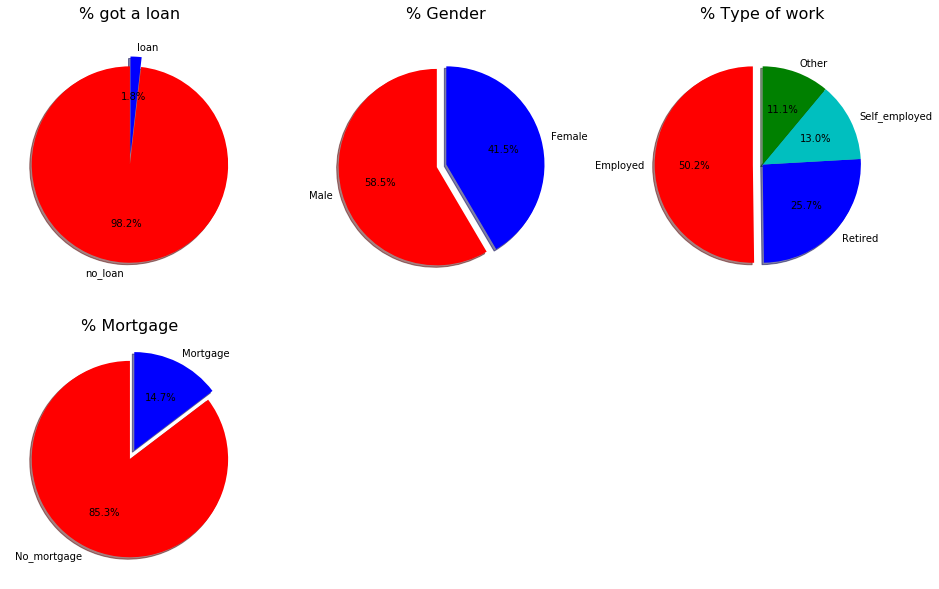

In [29]:
# pie with scores

#slices-count each score

# pie with scores

df = categorical_file_final_graph.copy() 
compare_col_graph= 'contrata_consumo'

val1,val2 = 0,1

''' count number clientes with and without loan'''
no_loan = df.loc[df[compare_col_graph] == val1].count()
loan = df.loc[df[compare_col_graph] == val2].count()

plt.subplot(2, 3, 1)
title4 = '% got a loan\n'
plt.title(title4,fontsize = 16)
slices = [pd.Series(no_loan)[0],pd.Series(loan)[0]]
activities = ['no_loan','loan']
cols = ['r', 'b']
# plt

'''startangle :Angle from where the pie partitions start. In this case perpendicular to the tittle'''
'''shade: shade on the graph'''
'''explode: outstand some of the pie parts'''
'''autopct:include the percentage'''
plt.pie (slices,
        labels = activities,
        colors = cols,
        startangle = 90,  
        shadow = True,     
        explode = (0,0.1),  
        autopct = '%1.1f%%')  

# pie with gender

plt.subplot(2, 3, 2)
plt.subplots_adjust(right = 2)
title5 = '% Gender\n'
val1,val2 = 1,0

plt.title(title5,fontsize = 16)
compare_col_graph_gender= 'sexo_dum'

male = df.loc[df[compare_col_graph_gender] == val1].count()
female = df.loc[df[compare_col_graph_gender] == val2].count() 

slices_gender = [pd.Series(male)[0],pd.Series(female)[0]]
activities_gender = ['Male','Female']
cols_gender = ['r','b']


plt.pie (slices_gender,
        labels = activities_gender,
        colors = cols_gender,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0),
        autopct = '%1.1f%%')

# pie with type of work

plt.subplot(2, 3, 3)
plt.subplots_adjust(right = 2.2)
title6 = '% Type of work\n'
val1,val2,val3,val4 = 0,1,3,2
plt.title(title6,fontsize = 16)
compare_col_graph_work= 'tiptraba_dum'

employed = df.loc[df[compare_col_graph_work] == val1].count()
retired = df.loc[df[compare_col_graph_work] == val2].count() 
self_employed = df.loc[df[compare_col_graph_work] == val3].count()
other = df.loc[df[compare_col_graph_work] == val4].count() 

slices_work = [pd.Series(employed)[0],pd.Series(retired)[0],pd.Series(self_employed)[0],pd.Series(other)[0]]
activities_work = ['Employed','Retired','Self_employed','Other']
cols_work = ['r', 'b', 'c','g']



plt.pie (slices_work,
        labels = activities_work,
        colors = cols_work,
        startangle = 90,  
        shadow = True,    
        explode = (0.1,0,0,0), 
        autopct = '%1.1f%%')  



# pie with mortgage

plt.subplot(2, 3, 4)
plt.subplots_adjust(top = 2)
title7 = '% Mortgage'
val1,val2 = 0,1

plt.title(title7,fontsize = 16)
compare_col_graph_mortgage= 'H2496_INDHIPOT_dum'

no_mortgage = df.loc[df[compare_col_graph_mortgage] == val1].count()
mortgage = df.loc[df[compare_col_graph_mortgage] == val2].count() 


slices_mortgage = [pd.Series(no_mortgage)[0],pd.Series(mortgage)[0]]
activities_mortgage = ['No_mortgage','Mortgage']
cols_mortgage = ['r','b']
# plt


plt.pie (slices_mortgage,
        labels = activities_mortgage,
        colors = cols_mortgage,
        startangle = 90,  
        shadow = True,    
        explode = (0,0.1),
        autopct = '%1.1f%%')

plt.show()




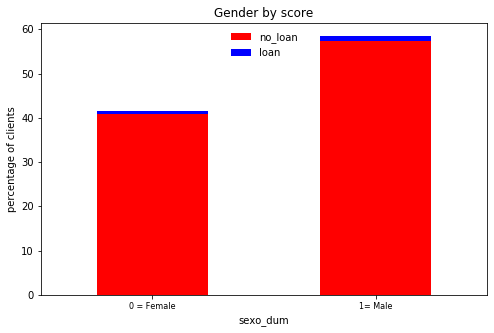

contrata_consumo      0     1
sexo_dum                     
female            40.81  0.71
male              57.37  1.10


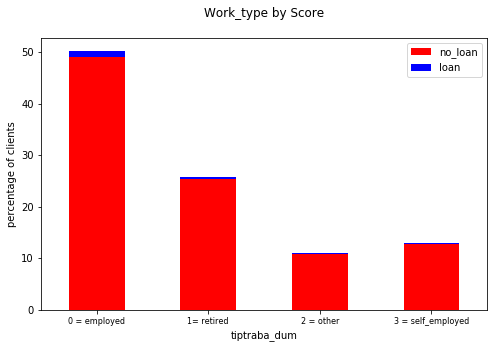

contrata_consumo      0     1
tiptraba_dum                 
employed          49.07  1.13
retired           25.40  0.30
other             10.91  0.14
self_employed     12.80  0.24


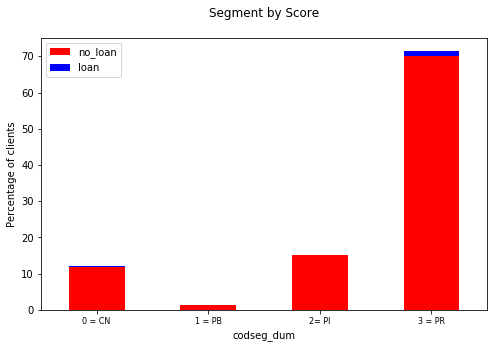

contrata_consumo      0     1
codseg_dum                   
CN                11.74  0.24
PB                 1.34  0.01
PI                15.05  0.15
PR                70.04  1.41


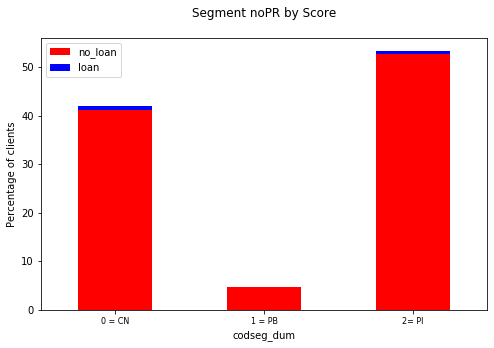

contrata_consumo      0     1
codseg_dum                   
CN                41.14  0.85
PB                 4.70  0.04
PI                52.74  0.53


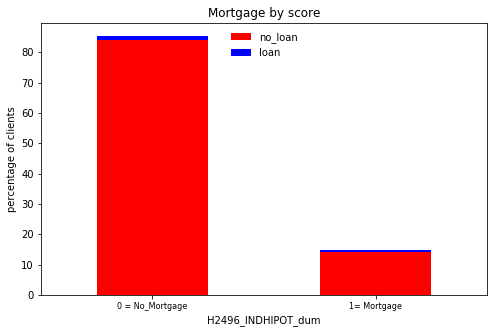

contrata_consumo        0     1
H2496_INDHIPOT_dum             
mortgage_no         83.89  1.45
mortgage_yes        14.29  0.37


In [30]:
#  plot with more details the cols stant out previously


# stacked graph

values_scored =  [0,1]

colors = ["r", "b"]

# gender

''' create df only with the columns i need'''
df_ge = df[['contrata_consumo','sexo_dum']]

''' group creating a new column cunting the clients for each group'''
df_group_ge = df_ge.groupby(['contrata_consumo','sexo_dum'])['contrata_consumo'].count().reset_index(name="count")
''' create percentage for each group category'''
percentage_dist_ge = 100 * df_group_ge[['count']].divide(df_group_ge[['count']].sum(), axis = 1)
''' drop the count so i keep only the percentage column'''
df_group_ge.drop(columns= 'count', inplace = True)
'''ad the percentage column '''
gender_df= pd.concat([df_group_ge,percentage_dist_ge],axis = 1)

gender_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
'''transpose the df to create the stacked bar plot '''
pivot_df_ge = gender_df.pivot(index='sexo_dum', columns='contrata_consumo', values='percentage')

pivot_df_ge.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))

''' transpose to show the detail table underneath and rename the lengend '''
rename_df_ge = pivot_df_ge.rename(columns={"0": "No-Loan", "1": "Loan"},index={0 :"female",1: "male"})
'''round the values in the table underneath bar plot'''
rename_df_ge_r =rename_df_ge.round(2)

plt.title('Gender by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = Female','1= Male'],size = 8,rotation=0)
'''rename the legend and plot it in the center'''
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_ge_r)


# type of work

df_wt = df[['contrata_consumo','tiptraba_dum']]
df_group_wt = df_wt.groupby(['contrata_consumo','tiptraba_dum'])['contrata_consumo'].count().reset_index(name="count")

percentage_dist_tiptrab = 100 * df_group_wt[['count']].divide(df_group_wt[['count']].sum(), axis = 1)
df_group_wt.drop(columns= 'count', inplace = True)

tiptraba_df= pd.concat([df_group_wt,percentage_dist_tiptrab],axis = 1)

tiptraba_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_wt = tiptraba_df.pivot(index='tiptraba_dum', columns='contrata_consumo', values='percentage')

pivot_df_wt.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_wt = pivot_df_wt.rename(columns={"0": "No-Loan", "1": "Loan"},
                                  index={0 :"employed", 1: "retired",2:"other",3:"self_employed"})
                                                
rename_df_wt_r =rename_df_wt.round(2)

plt.title('Work_type by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(4), ['0 = employed','1= retired', '2 = other', '3 = self_employed'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()
print(rename_df_wt_r)


# codseg_dum

df_seg = df[['contrata_consumo','codseg_dum']]
df_group_seg = df_seg.groupby(['contrata_consumo','codseg_dum'])['contrata_consumo'].count().reset_index(name="count")
percentage_dist_seg = 100 * df_group_seg[['count']].divide(df_group_seg[['count']].sum(), axis = 1)
df_group_seg.drop(columns= 'count', inplace = True)
codseg_df= pd.concat([df_group_seg,percentage_dist_seg],axis = 1)

codseg_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg = codseg_df.pivot(index='codseg_dum', columns='contrata_consumo', values='percentage')
pivot_df_seg.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg = pivot_df_seg.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0: "CN", 1: "PB", 2: "PI",3 : "PR"})
rename_df_seg_r =rename_df_seg.round(2)
plt.title('Segment by Score\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(4), ['0 = CN','1 = PB','2= PI','3 = PR'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_r)



# Segmento sin PR

# inset = inset_axes(ax, 
#                    width="60%", # width = 30% of parent_bbox
#                    height=2.5, # height : 1 inch
#                    loc=10)

df_seg_npr = df_seg.loc[df_seg['codseg_dum'] != 3]
df_group_seg_npr = df_seg_npr.groupby(['contrata_consumo','codseg_dum'])['contrata_consumo'].count().reset_index(name="count")
percentage_dist_seg_npr = 100 * df_group_seg_npr[['count']].divide(df_group_seg_npr[['count']].sum(), axis = 1)
df_group_seg_npr.drop(columns= 'count', inplace = True)
codseg_nopr_df= pd.concat([df_group_seg_npr,percentage_dist_seg_npr],axis = 1)

codseg_nopr_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg_npr = codseg_nopr_df.pivot(index='codseg_dum', columns='contrata_consumo', values='percentage')
pivot_df_seg_npr.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg_npr = pivot_df_seg_npr.rename(columns={"0": "No-Loan", "1": "Loan"},
                                            index={0: "CN", 1: "PB", 2: "PI"})
rename_df_seg_npr_r =rename_df_seg_npr.round(2)

plt.title('Segment noPR by Score\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(3), ['0 = CN','1 = PB','2= PI'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_npr_r )


#mortgage

df_mor = df[['contrata_consumo','H2496_INDHIPOT_dum']]
df_group_mor = df_mor.groupby(['contrata_consumo','H2496_INDHIPOT_dum'])['contrata_consumo'].count().reset_index(name="count")

percentage_dist_mor = 100 * df_group_mor[['count']].divide(df_group_mor[['count']].sum(), axis = 1)
df_group_mor.drop(columns= 'count', inplace = True)

mortgage_df= pd.concat([df_group_mor,percentage_dist_mor],axis = 1)

mortgage_df.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_mor = mortgage_df.pivot(index='H2496_INDHIPOT_dum', columns='contrata_consumo', values='percentage')

pivot_df_mor.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_mor = pivot_df_mor.rename(columns={"0": "No-Loan", "1": "Loan"},
                                    index={0 :"mortgage_no",1: "mortgage_yes"})
rename_df_mor_r =rename_df_mor.round(2)
plt.title('Mortgage by score')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No_Mortgage','1= Mortgage'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_mor_r)

C:\Users\N58645\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


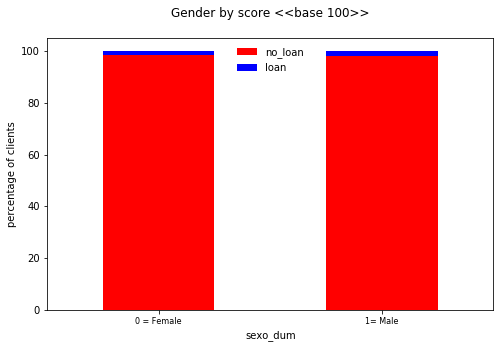

contrata_consumo      0     1
sexo_dum                     
female            98.28  1.72
male              98.11  1.89


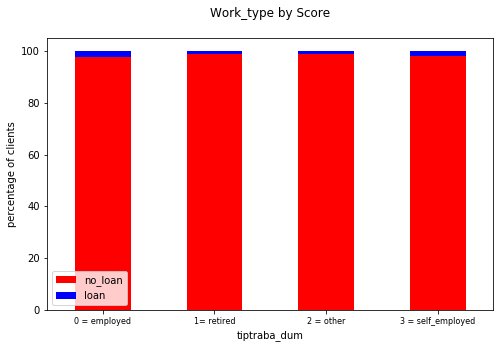

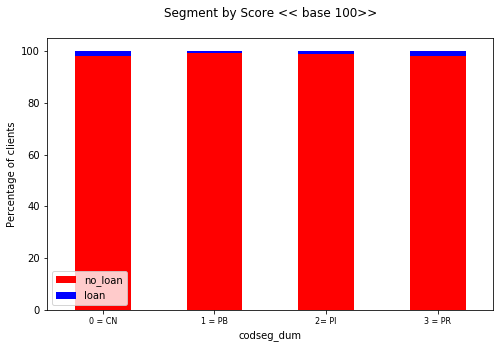

contrata_consumo      0     1
codseg_dum                   
CN                97.99  2.01
PB                99.14  0.86
PI                99.01  0.99
PR                98.02  1.98


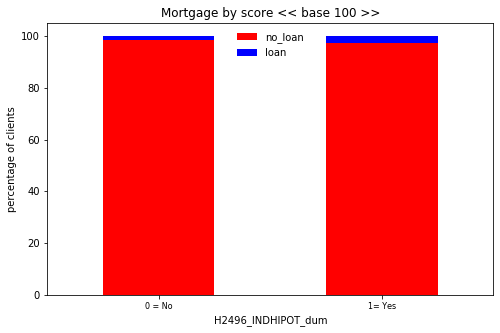

contrata_consumo        0     1
H2496_INDHIPOT_dum             
mortgage_no         98.31  1.69
mortgage_yes        97.45  2.55


In [31]:
# study to understand under which conditions the model gives a higher probability of getting a loan

# gender base 100
''' create df only with the columns i need'''
df_gender = df[['contrata_consumo','sexo_dum']]
''' group creating a new column cunting the clients for each group'''
df_group_gender = df_gender.groupby(['contrata_consumo','sexo_dum'])['contrata_consumo'].count().reset_index(name="count")
''' create percentage for each group category. In this case female and male'''
df_group_gender_0 =df_group_gender[df_group_gender['sexo_dum'] == 0]
percentage_dist_gender_0 = 100 * df_group_gender_0[['count']].divide(df_group_gender_0[['count']].sum(), axis = 1)
''' drop the count so i keep only the percentage column'''
df_group_gender_0.drop(columns= 'count', inplace = True)
'''ad the percentage column '''
gender_d_0= pd.concat([df_group_gender_0,percentage_dist_gender_0],axis = 1)


df_group_gender_1 =df_group_gender[df_group_gender['sexo_dum'] == 1]
percentage_dist_gender_1 = 100 * df_group_gender_1[['count']].divide(df_group_gender_1[['count']].sum(), axis = 1)
df_group_gender_1.drop(columns= 'count', inplace = True)
gender_d_1= pd.concat([df_group_gender_1,percentage_dist_gender_1],axis = 1)


gender_df_base100= pd.concat([gender_d_0,gender_d_1],axis = 0)
gender_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
'''transpose the df to create the stacked bar plot '''
pivot_df_ge_base100 = gender_df_base100.pivot(index='sexo_dum', columns='contrata_consumo', values='percentage')

pivot_df_ge_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
''' transpose to show the detail table underneath and rename the lengend '''
rename_df_ge_base100 = pivot_df_ge_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"female",1: "male"})
'''round the values in the table underneath bar plot'''
rename_df_ge_r_base100 =rename_df_ge_base100.round(2)
plt.title('Gender by score <<base 100>>\n')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = Female','1= Male'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_ge_r_base100)

# type of work base 100

df_wt = df[['contrata_consumo','tiptraba_dum']]
df_group_wt = df_wt.groupby(['contrata_consumo','tiptraba_dum'])['contrata_consumo'].count().reset_index(name="count")

df_group_wt_0 =df_group_wt[df_group_wt['tiptraba_dum'] == 0]
percentage_dist_wt_0 = 100 * df_group_wt_0[['count']].divide(df_group_wt_0[['count']].sum(), axis = 1)
df_group_wt_0.drop(columns= 'count', inplace = True)
wt_d_0= pd.concat([df_group_wt_0,percentage_dist_wt_0],axis = 1)
    
df_group_wt_1 =df_group_wt[df_group_wt['tiptraba_dum'] == 1]
percentage_dist_wt_1 = 100 * df_group_wt_1[['count']].divide(df_group_wt_1[['count']].sum(), axis = 1)
df_group_wt_1.drop(columns= 'count', inplace = True)
wt_d_1= pd.concat([df_group_wt_1,percentage_dist_wt_1],axis = 1)

df_group_wt_2 =df_group_wt[df_group_wt['tiptraba_dum'] == 2]
percentage_dist_wt_2 = 100 * df_group_wt_2[['count']].divide(df_group_wt_2[['count']].sum(), axis = 1)
df_group_wt_2.drop(columns= 'count', inplace = True)
wt_d_2= pd.concat([df_group_wt_2,percentage_dist_wt_2],axis = 1)

df_group_wt_3=df_group_wt[df_group_wt['tiptraba_dum'] == 3]
percentage_dist_wt_3 = 100 * df_group_wt_3[['count']].divide(df_group_wt_3[['count']].sum(), axis = 1)
df_group_wt_3.drop(columns= 'count', inplace = True)
wt_d_3= pd.concat([df_group_wt_3,percentage_dist_wt_3],axis = 1)

wt_df_base100= pd.concat([wt_d_0,wt_d_1,wt_d_2,wt_d_3],axis = 0)

wt_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_wt_base100 = wt_df_base100.pivot(index='tiptraba_dum', columns='contrata_consumo', values='percentage')

pivot_df_wt_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_wt_base100 = pivot_df_wt_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                  index={0 :"employed",1: "retired",2:"other",3:"self_employed"})
rename_df_wt_r_base100 =rename_df_wt_base100.round(2)
plt.title('Work_type by Score\n')
plt.ylabel('percentage of clients')
plt.xticks (range(4), ['0 = employed','1= retired', '2 = other', '3 = self_employed'],rotation=0,size = 8)
plt.legend(labels = activities)
plt.show()


# codseg_dum base 100 


df_seg = df[['contrata_consumo','codseg_dum']]
df_group_seg = df_seg.groupby(['contrata_consumo','codseg_dum'])['contrata_consumo'].count().reset_index(name="count")

df_group_seg_0 =df_group_seg[df_group_seg['codseg_dum'] == 0]
percentage_dist_seg_0 = 100 * df_group_seg_0[['count']].divide(df_group_seg_0[['count']].sum(), axis = 1)
df_group_seg_0.drop(columns= 'count', inplace = True)
seg_d_0= pd.concat([df_group_seg_0,percentage_dist_seg_0],axis = 1)
    
df_group_seg_1 =df_group_seg[df_group_seg['codseg_dum'] == 1]
percentage_dist_seg_1 = 100 * df_group_seg_1[['count']].divide(df_group_seg_1[['count']].sum(), axis = 1)
df_group_seg_1.drop(columns= 'count', inplace = True)
seg_d_1= pd.concat([df_group_seg_1,percentage_dist_seg_1],axis = 1)

df_group_seg_2 =df_group_seg[df_group_seg['codseg_dum'] == 2]
percentage_dist_seg_2 = 100 * df_group_seg_2[['count']].divide(df_group_seg_2[['count']].sum(), axis = 1)
df_group_seg_2.drop(columns= 'count', inplace = True)
seg_d_2= pd.concat([df_group_seg_2,percentage_dist_seg_2],axis = 1)

df_group_seg_3=df_group_seg[df_group_seg['codseg_dum'] == 3]
percentage_dist_seg_3 = 100 * df_group_seg_3[['count']].divide(df_group_seg_3[['count']].sum(), axis = 1)
df_group_seg_3.drop(columns= 'count', inplace = True)
seg_d_3= pd.concat([df_group_seg_3,percentage_dist_seg_3],axis = 1)

seg_df_base100= pd.concat([seg_d_0,seg_d_1,seg_d_2,seg_d_3],axis = 0)

seg_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_seg_base100 = seg_df_base100.pivot(index='codseg_dum', columns='contrata_consumo', values='percentage')

pivot_df_seg_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_seg_base100 = pivot_df_seg_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"CN",1: "PB",2:"PI",3:"PR"})
rename_df_seg_r_base100 =rename_df_seg_base100.round(2)
plt.title('Segment by Score << base 100>>\n')
plt.ylabel('Percentage of clients')
plt.xticks (range(4), ['0 = CN','1 = PB','2= PI','3 = PR'],size = 8,rotation = 0)
plt.legend(labels = activities)
plt.show()
print(rename_df_seg_r_base100)



# mortgage base 100

df_mor = df[['contrata_consumo','H2496_INDHIPOT_dum']]
df_group_mor = df_mor.groupby(['contrata_consumo','H2496_INDHIPOT_dum'])['contrata_consumo'].count().reset_index(name="count")

df_group_mor_0 =df_group_mor[df_group_mor['H2496_INDHIPOT_dum'] == 0]
percentage_dist_mor_0 = 100 * df_group_mor_0[['count']].divide(df_group_mor_0[['count']].sum(), axis = 1)
df_group_mor_0.drop(columns= 'count', inplace = True)
mortgage_d_0= pd.concat([df_group_mor_0,percentage_dist_mor_0],axis = 1)
mortgage_d_0

df_group_mor_1 =df_group_mor[df_group_mor['H2496_INDHIPOT_dum'] == 1]
percentage_dist_mor_1 = 100 * df_group_mor_1[['count']].divide(df_group_mor_1[['count']].sum(), axis = 1)
df_group_mor_1.drop(columns= 'count', inplace = True)
mortgage_d_1= pd.concat([df_group_mor_1,percentage_dist_mor_1],axis = 1)
mortgage_d_1

mortgage_df_base100= pd.concat([mortgage_d_0,mortgage_d_1],axis = 0)

mortgage_df_base100.rename(columns={ 'count' : 'percentage'}, inplace=True)
pivot_df_mor_base100 = mortgage_df_base100.pivot(index='H2496_INDHIPOT_dum', columns='contrata_consumo', values='percentage')

pivot_df_mor_base100.loc[:,values_scored].plot.bar(stacked=True, color=colors, figsize=(8,5))
rename_df_mor_base100 = pivot_df_mor_base100.rename(columns={"0": "No-Loan", "1": "Loan"},
                                                    index={0 :"mortgage_no",1: "mortgage_yes"})
rename_df_mor_r_base100 =rename_df_mor_base100.round(2)
plt.title('Mortgage by score << base 100 >>')
plt.ylabel('percentage of clients')
plt.xticks (range(2), ['0 = No','1= Yes'],size = 8,rotation=0)
plt.legend(loc='upper center',labels = activities, frameon=False)
plt.show()
print(rename_df_mor_r_base100)


### b.Numerical features visualization

C:\Users\N58645\anaconda3\lib\site-packages\seaborn\distributions.py:323: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot(x, y, color=color, label=label, **kwargs)


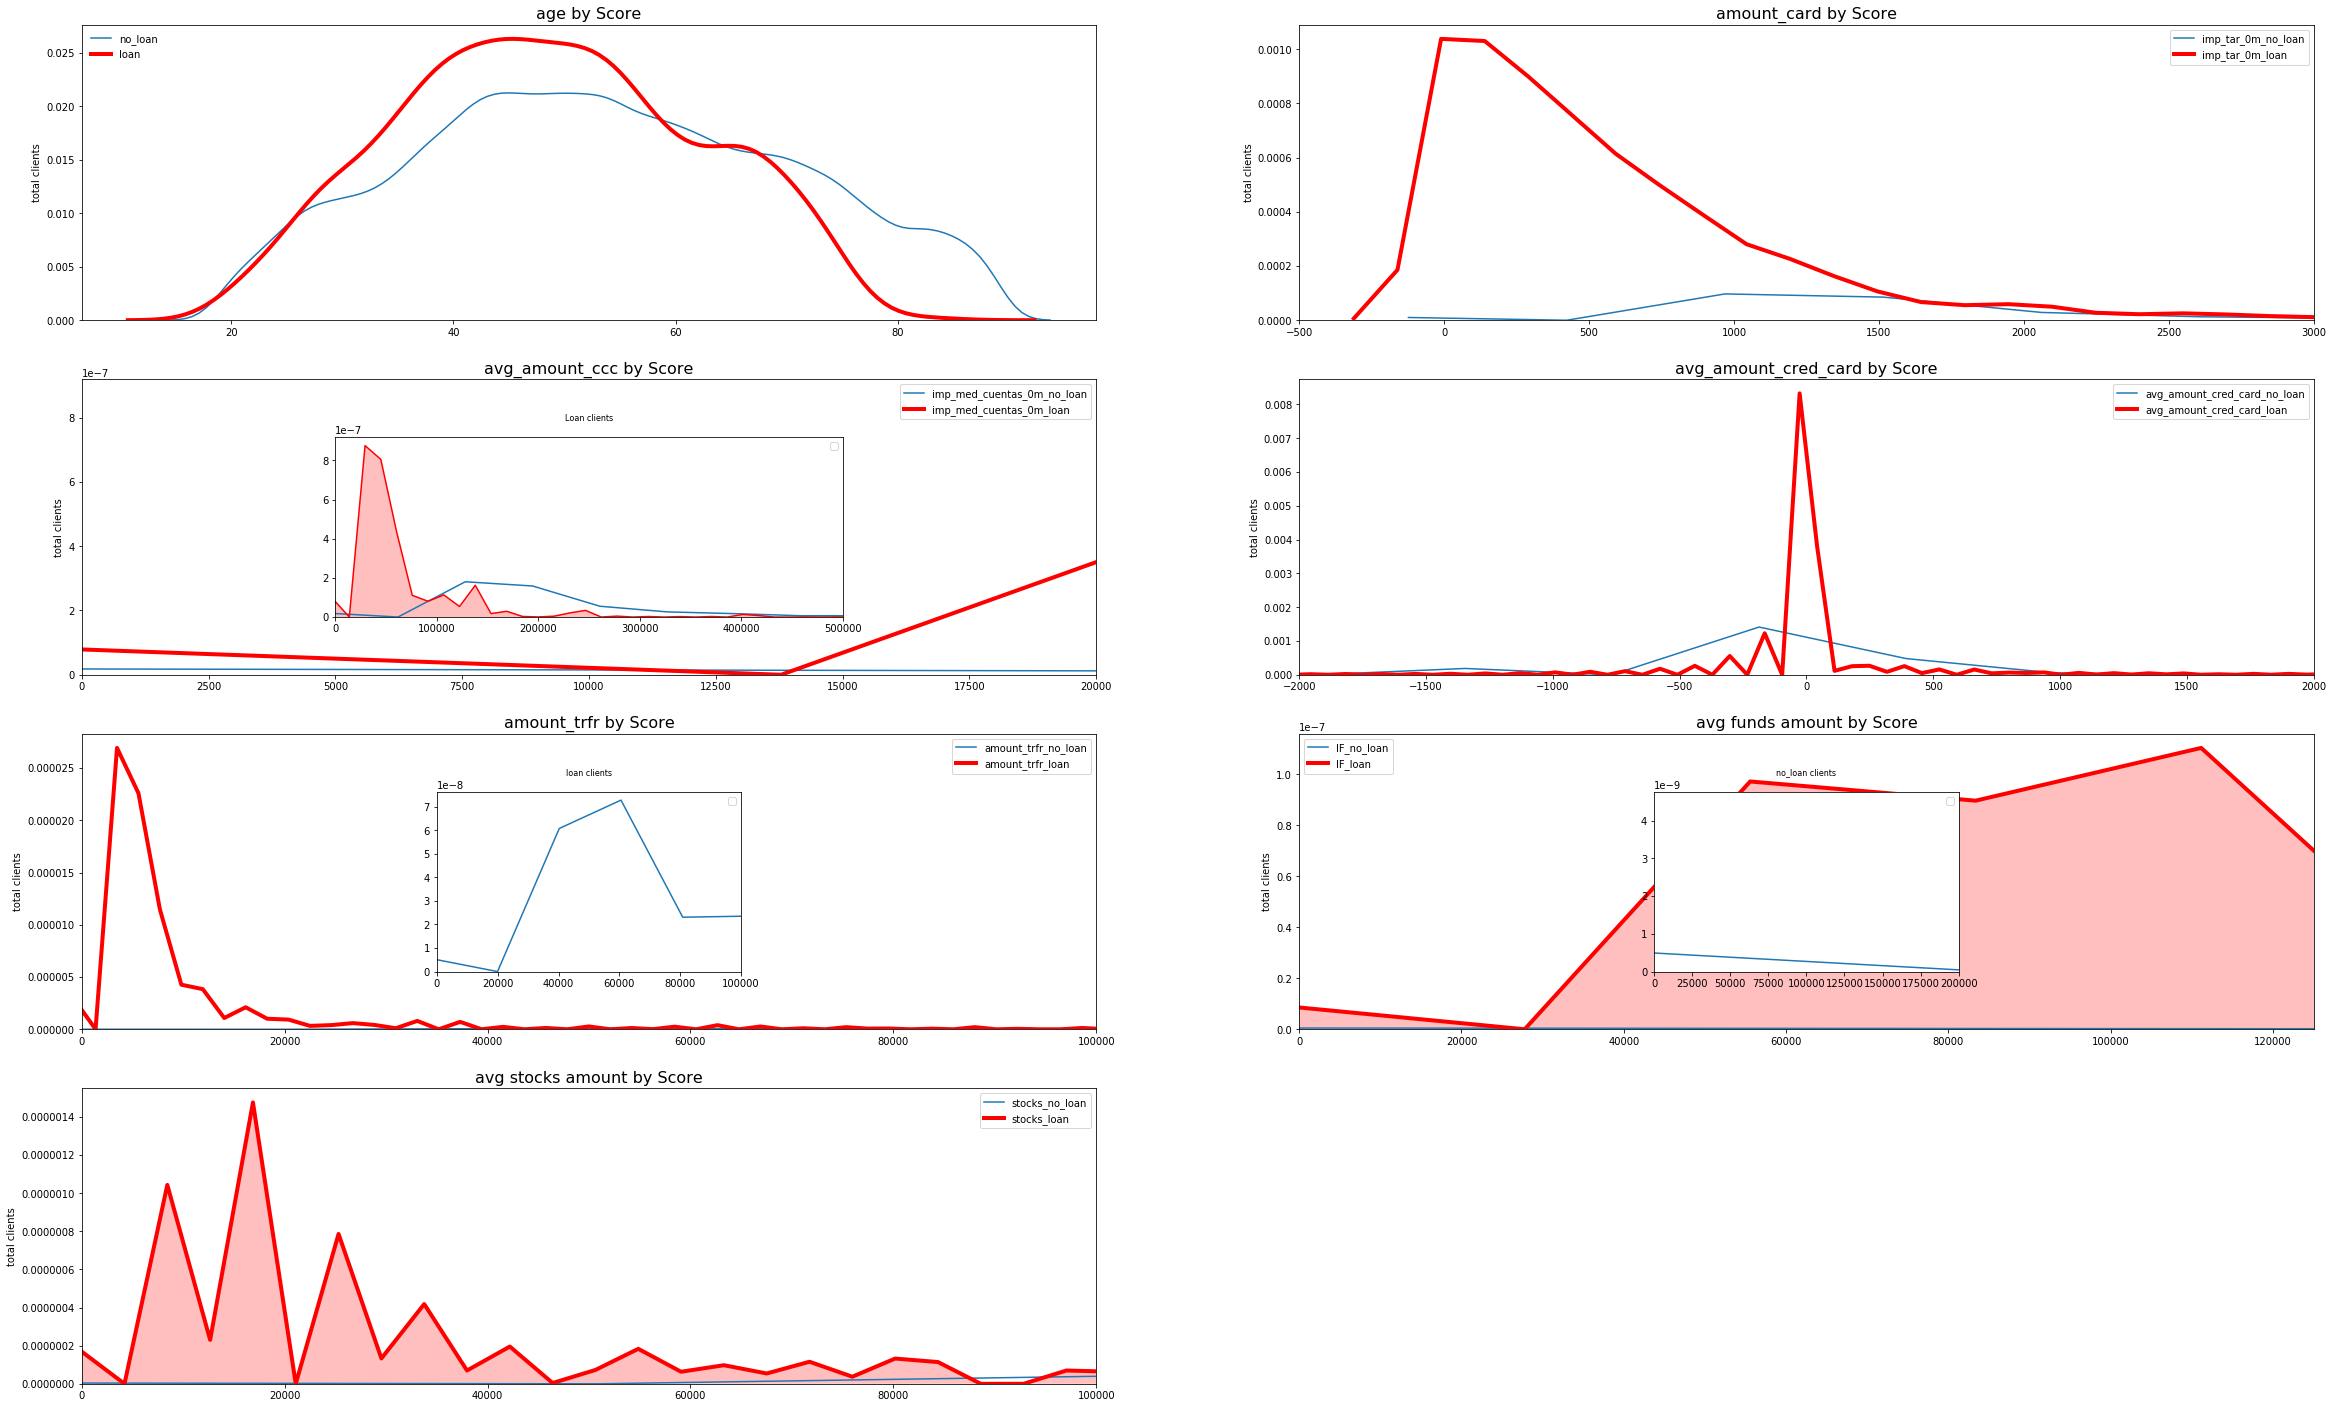

In [32]:
# plot with more details the cols stant out previously
from seaborn import kdeplot 

# graph_df = pd.concat([total_clients_mod['contrata_consumo'], categorical_file_final_graph],axis =1)

graph_df = total_clients_mod.copy()

compare_col_graph = 'contrata_consumo'

val1,val2 = 0,1

''' count number clientes with and without loan'''
no_loan_graph = graph_df.loc[graph_df[compare_col_graph] == val1]
loan_graph = graph_df.loc[graph_df[compare_col_graph] == val2]


plt.figure(figsize=(40,25))
plt.subplot(4, 2, 1)

# age
plt.title('age by Score',fontsize = 16)
kdeplot(no_loan_graph.edad,label='no_loan',)
kdeplot(loan_graph.edad,label='loan',linewidth=4,c='r')
plt.legend(loc='upper left',frameon=False)
plt.ylabel('total clients')


# imp_tar_0m
plt.subplot(4, 2, 2)

plt.title('amount_card by Score',fontsize = 16)

kdeplot(no_loan_graph.imp_tar_0m,label= 'imp_tar_0m_no_loan')
kdeplot(loan_graph.imp_tar_0m,label='imp_tar_0m_loan',linewidth=4,c='r')

plt.xlim(-500, 3000)
plt.ylabel('total clients')


# imp_med_cuentas

ax = plt.subplot(4, 2, 3)

plt.title('avg_amount_ccc by Score',fontsize = 16)

kdeplot(no_loan_graph.imp_med_cuentas_0m,label= 'imp_med_cuentas_0m_no_loan')
kdeplot(loan_graph.imp_med_cuentas_0m,label='imp_med_cuentas_0m_loan', linewidth=4,c='r')
plt.xlim(0, 20000)
plt.ylabel('total clients')
inset = inset_axes(ax, 
                   width="50%", # width = 30% of parent_bbox
                   height=2.5, # height : 1 inch
                   loc=10)

plt.title('Loan clients\n',fontsize = 8)
kdeplot(no_loan_graph.imp_med_cuentas_0m)
kdeplot(loan_graph.imp_med_cuentas_0m, shade = True,c='r')
plt.xlim(0, 500000)
plt.legend('')


# imp_med_tarj_credito_0m

plt.subplot(4, 2, 4)

plt.title('avg_amount_cred_card by Score',fontsize = 16)

kdeplot(no_loan_graph.imp_med_tarj_credito_0m,label='avg_amount_cred_card_no_loan')
kdeplot(loan_graph.imp_med_tarj_credito_0m,label='avg_amount_cred_card_loan',linewidth=4,c='r')
plt.xlim(-2000,2000)
plt.ylabel('total clients')
# imp_trfr_0m

ax = plt.subplot(4, 2, 5)

plt.title('amount_trfr by Score',fontsize = 16)

kdeplot(no_loan_graph.imp_trfr_0m,label='amount_trfr_no_loan')
kdeplot(loan_graph.imp_trfr_0m,label='amount_trfr_loan',linewidth=4,c='r')
plt.xlim(0,100000)
plt.legend(loc = 'upper right')
plt.ylabel('total clients')

inset = inset_axes(ax, 
                   width="30%", # width = 30% of parent_bbox
                   height=2.5, # height : 1 inch
                   loc=10)

plt.title('loan clients\n',fontsize = 8)
kdeplot(no_loan_graph.imp_trfr_0m)
# kdeplot(loan_graph.imp_trfr_0m,shade = True)
plt.xlim(0,100000)
plt.legend('')

# imp_med_fondos_0m

ax=plt.subplot(4, 2, 6)

plt.title('avg funds amount by Score',fontsize = 16)

kdeplot(no_loan_graph.imp_med_fondos_0m,label='IF_no_loan')
kdeplot(loan_graph.imp_med_fondos_0m,label='IF_loan',linewidth=4,shade = True,c='r')
plt.xlim(0,125000)
plt.ylabel('total clients')

inset = inset_axes(ax, 
                   width="30%", # width = 30% of parent_bbox
                   height=2.5, # height : 1 inch
                   loc=10)

plt.title('no_loan clients\n',fontsize = 8)
kdeplot(no_loan_graph.imp_med_fondos_0m)
# kdeplot(loan_graph.imp_trfr_0m,shade = True)
plt.xlim(0,200000)
plt.legend('')

# imp_med_valores_0m

plt.subplot(4, 2, 7)

plt.title('avg stocks amount by Score',fontsize = 16)

kdeplot(no_loan_graph.imp_med_valores_0m,label='stocks_no_loan')
kdeplot(loan_graph.imp_med_valores_0m,label='stocks_loan',linewidth=4,shade = True,c='r')
plt.xlim(0,100000)
plt.ylabel('total clients')

plt.show()


### GPS 

In [58]:
polygon_pc

,COD_PROV,NOM_PROV,COD_CCAA,geometry
0,01,ARABA/ÁLAVA,17,"POLYGON ((-2.83547 42.79627, -2.83340 42.79528..."
1,02,ALBACETE,06,"POLYGON ((-1.48366 39.41824, -1.48281 39.41852..."
2,03,ALACANT/ALICANTE,19,"MULTIPOLYGON (((-0.15968 38.88351, -0.16083 38..."
3,04,ALMERÍA,01,"MULTIPOLYGON (((-2.18191 37.89882, -2.18320 37..."
4,05,ÁVILA,07,"POLYGON ((-5.01386 41.16425, -5.01437 41.16386..."
5,06,BADAJOZ,10,"POLYGON ((-4.67789 39.43485, -4.67785 39.43535..."
6,07,ILLES BALEARS,03,"MULTIPOLYGON (((3.21365 39.95751, 3.21384 39.9..."
7,08,BARCELONA,08,"MULTIPOLYGON (((1.91821 42.31778, 1.91631 42.3..."
8,09,BURGOS,07,"MULTIPOLYGON (((-3.24918 43.19600, -3.25030 43..."
9,10,CÁCERES,10,"POLYGON ((-6.23048 40.48660, -6.23127 40.48665..."


In [33]:
# codigo me ha remitido yosu provincias  

# need to install first folium :conda install -c conda-forge folium
'''download the map 4 files to local folder and read de shp file '''
polygon_path = os.path.abspath("Provincias.shp")
polygon_pc = gpd.read_file(polygon_path)

''' select the column from my file,change column name to use as key with previous 
file polygon_pc and group the clients by postal code'''

pc_data = numerical_file[['cprovper']].rename(columns={ 'cprovper' : 'COD_CCAA'})
pc_data_gp=pc_data.groupby(['COD_CCAA'])['COD_CCAA'].count().reset_index(name="clients")

'''only with Loan'''

Loan = pd.concat([numerical_file[['cprovper']],categorical_file_final_graph[['contrata_consumo']]],axis = 1)
Loan['contrata_consumo'] = Loan['contrata_consumo'].astype('float')
Loan_filt = Loan[Loan['contrata_consumo']>= 0]
pc_data_hs = Loan_filt[['cprovper']].rename(columns={ 'cprovper' : 'COD_CCAA'})
pc_data_gp_hs=pc_data_hs.groupby(['COD_CCAA'])['COD_CCAA'].count().reset_index(name="clients")

'''weight no loan clients by province'''
weight_nl_clients = (pc_data_gp.clients/pc_data_gp.clients).to_frame()
weight_nl_clients_graph = pd.concat([pc_data_gp.COD_CCAA,weight_nl_clients],axis =1)

m = folium.Map(location=[ 40.4636688, -3.7492199], zoom_start=6)
data1 =folium.Choropleth(
       geo_data=polygon_pc,
       name='choropleth',
       data=pc_data_gp,
       columns=['COD_CCAA', 'clients'],
       key_on= 'feature.id',
       fill_color='YlOrRd',
       fill_opacity=0.6,
       line_opacity=0.2,
       highlight=True,
       show=True,
       legend_name='Clients by province'
).add_to(m)


data2 = folium.Choropleth(
        geo_data=polygon_pc,
        name='choropleth',
        data=weight_nl_clients_graph,
        columns=['COD_CCAA', 'clients'],
        key_on= 'feature.id',
        fill_color='YlGn',
        fill_opacity=0.6,
        line_opacity=0.2,
        legend_name='Weighted high scored Clients by province '
).add_to(m)
folium.LayerControl(collapsed=False).add_to(m)


m.save('Clients_by_province plus high score.html')

from IPython.display import HTML

# Global Surrogate Method

### a.Correlation between features

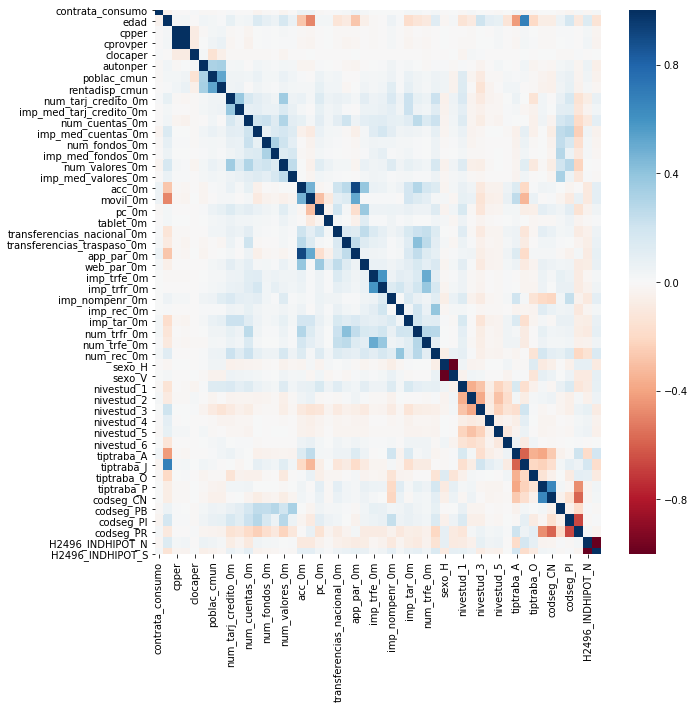

In [34]:
# I use a corr graph first between variables (si quiero % correlación ,annot=True)
plt.figure(figsize=(10,10))
sns.heatmap(total_clients_mod.corr(), cmap= 'RdBu')

In [35]:
# Top varibles por correlacion 

pd.set_option('display.max_rows',60)

def get_redundant_pairs(total_clients_mod):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = total_clients_mod.columns
    for i in range(0, total_clients_mod.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(total_clients_mod, n=5):
    au_corr = total_clients_mod.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(total_clients_mod)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(total_clients_mod, 60))

Top Absolute Correlations
H2496_INDHIPOT_N            H2496_INDHIPOT_S              1.000000
sexo_H                      sexo_V                        1.000000
cpper                       cprovper                      0.996214
acc_0m                      app_par_0m                    0.906393
edad                        tiptraba_J                    0.686118
codseg_PI                   codseg_PR                     0.670024
tiptraba_P                  codseg_CN                     0.654651
imp_trfe_0m                 imp_trfr_0m                   0.590918
tiptraba_A                  tiptraba_J                    0.590472
codseg_CN                   codseg_PR                     0.583867
poblac_cmun                 rentadisp_cmun                0.524592
movil_0m                    app_par_0m                    0.513932
imp_trfe_0m                 num_trfe_0m                   0.506868
edad                        movil_0m                      0.489638
acc_0m                      movil_0m

C:\Users\N58645\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\N58645\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


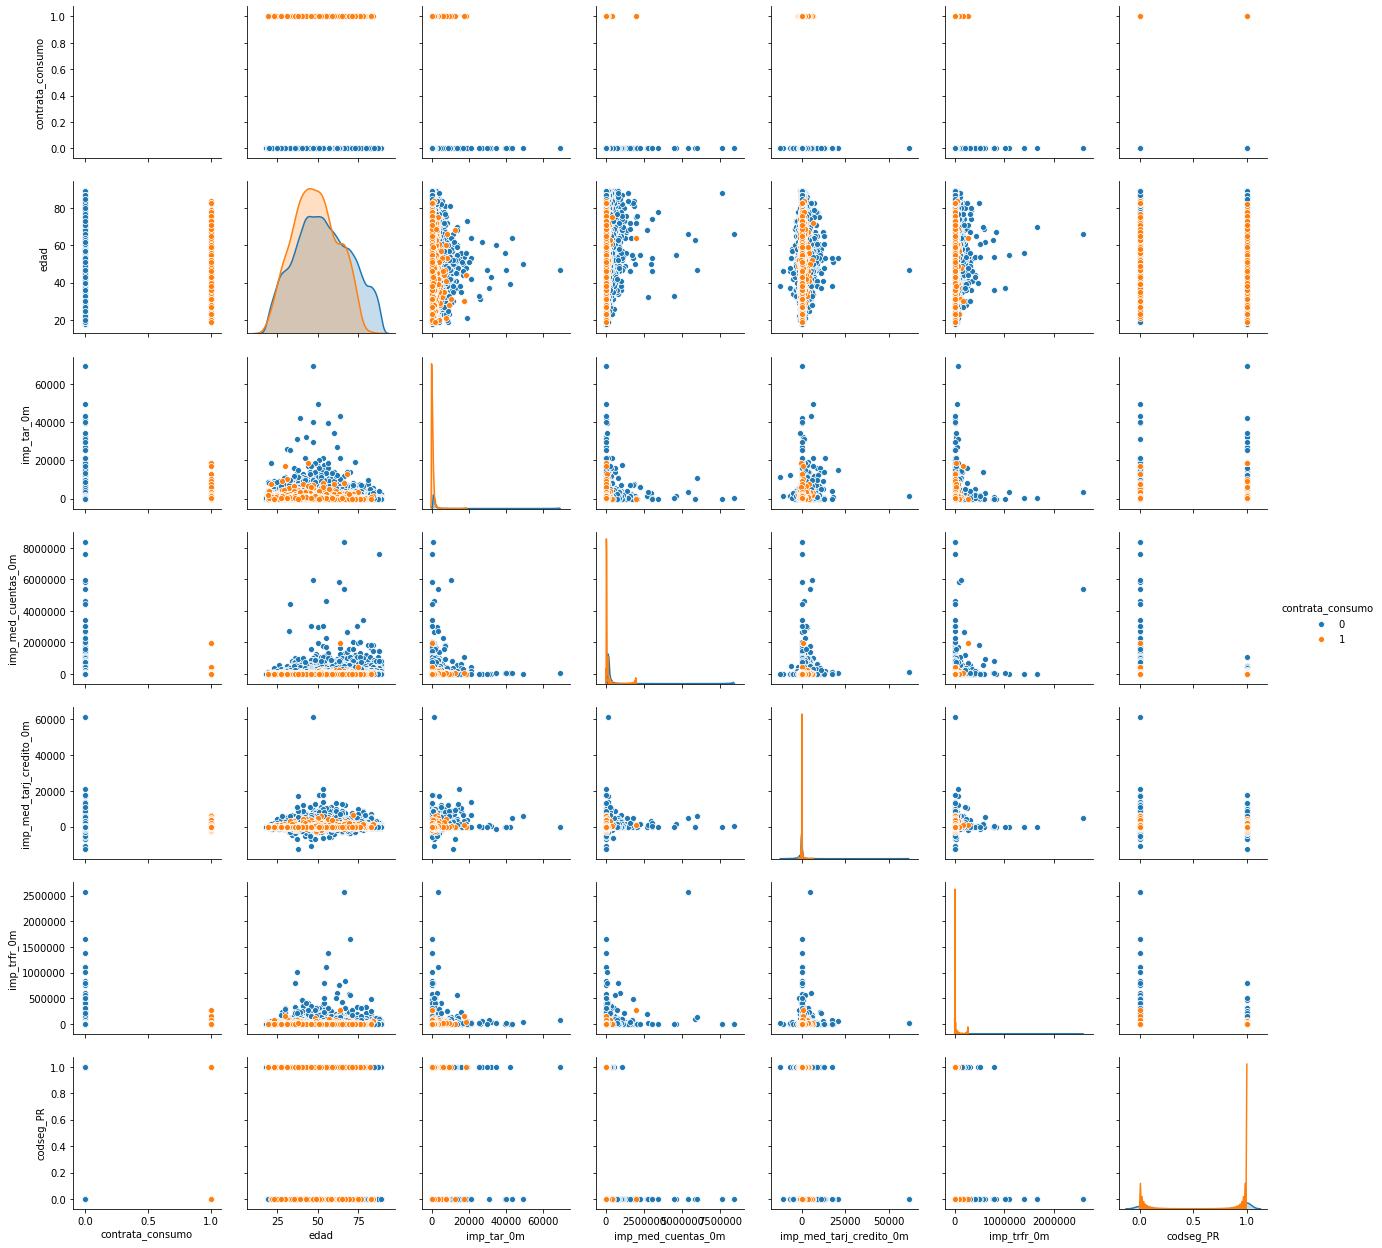

In [36]:
# Basic pairplot correlogram 

''' select columns with higher correlation vs score'''
# add_score = pd.concat([total_clients_mod, total_clients_file_ini[['contrata_consumo']]],axis =1)
mini_total_clients_mod = total_clients_mod[['contrata_consumo','edad','imp_tar_0m','imp_med_cuentas_0m','imp_med_tarj_credito_0m','imp_trfr_0m','codseg_PR']]
sns.pairplot(mini_total_clients_mod, hue = 'contrata_consumo') 



### b. normalize data

In [37]:
# normalize data. 
total_clients_mod_norm =total_clients_mod.copy()

features_to_normalize = ['edad','cpper', 'cprovper', 'clocaper',
       'poblac_cmun', 'rentadisp_cmun', 
       'imp_med_tarj_credito_0m',  'imp_med_cuentas_0m',
        'imp_med_fondos_0m','num_valores_0m', 
       'imp_med_valores_0m', 'acc_0m', 'movil_0m', 'pc_0m', 'tablet_0m',
       'transferencias_nacional_0m', 'app_par_0m','web_par_0m','transferencias_traspaso_0m',
        'imp_trfe_0m', 'imp_trfr_0m',
       'imp_nompenr_0m', 'imp_rec_0m', 'imp_tar_0m', 'num_trfr_0m',
        'num_trfe_0m','num_rec_0m']

total_clients_mod_norm[features_to_normalize] = total_clients_mod_norm[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))



In [38]:
total_clients_mod

,contrata_consumo,edad,cpper,cprovper,clocaper,autonper,poblac_cmun,rentadisp_cmun,num_tarj_credito_0m,imp_med_tarj_credito_0m,num_cuentas_0m,imp_med_cuentas_0m,num_fondos_0m,imp_med_fondos_0m,num_valores_0m,imp_med_valores_0m,acc_0m,movil_0m,pc_0m,tablet_0m,transferencias_nacional_0m,transferencias_traspaso_0m,app_par_0m,web_par_0m,imp_trfe_0m,imp_trfr_0m,imp_nompenr_0m,imp_rec_0m,imp_tar_0m,num_trfr_0m,num_trfe_0m,num_rec_0m,sexo_H,sexo_V,nivestud_1,nivestud_2,nivestud_3,nivestud_4,nivestud_5,nivestud_6,tiptraba_A,tiptraba_J,tiptraba_O,tiptraba_P,codseg_CN,codseg_PB,codseg_PI,codseg_PR,H2496_INDHIPOT_N,H2496_INDHIPOT_S
0,0,78,38006.0,38.0,419,5.0,203692.0,22339,1,-88.209999,1,1279.300049,0,0.000,0,0.00,2,0.000000,1.000000,0.000000,0,0,0,2,156.869995,1347.560059,1347.560059,1195.729980,506.279999,1,2,11,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
1,0,87,39527.0,39.0,888,6.0,0.0,0,0,0.000000,2,30566.779297,2,1830280.625,2,1893829.25,0,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,1172.130005,0.000000,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
2,0,81,32910.0,32.0,2327,12.0,5184.0,17802,0,0.000000,2,14419.440430,0,0.000,0,0.00,0,0.000000,0.000000,0.000000,0,0,0,0,0.000000,392.000000,392.000000,56.410000,150.130005,1,0,2,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0
3,0,78,33590.0,33.0,90785,3.0,1753.0,15894,0,0.000000,1,1111.979980,0,0.000,1,3.58,0,0.000000,0.000000,0.000000,0,0,0,0,10.000000,3380.879883,1380.880005,145.710007,683.700012,2,1,2,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0
5,0,70,28703.0,28.0,490,13.0,86707.0,26447,2,135.050003,1,113780.796875,0,0.000,1,3.58,12,1.000000,0.000000,0.000000,0,0,12,0,0.000000,2768.649902,1300.140015,1367.260010,722.130005,4,0,10,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199992,0,19,50001.0,50.0,0,2.0,664938.0,22358,0,0.000000,1,29.020000,0,0.000,0,0.00,8,1.000000,0.000000,0.000000,0,0,8,0,0.000000,0.000000,0.000000,25.900000,9.700000,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1,0
199993,0,21,14720.0,14.0,0,1.0,7982.0,13948,0,0.000000,1,361.940002,0,0.000,0,0.00,27,0.888889,0.037037,0.074074,0,0,14,8,505.000000,758.400024,0.000000,0.000000,239.339996,2,2,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
199994,0,22,46900.0,46.0,0,10.0,80630.0,19906,0,0.000000,1,46.509998,0,0.000,0,0.00,54,1.000000,0.000000,0.000000,0,0,20,0,0.000000,474.000000,0.000000,43.959999,129.649994,3,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0
199996,0,25,28053.0,28.0,0,13.0,3182981.0,29400,0,0.000000,1,77.419998,0,0.000,0,0.00,8,1.000000,0.000000,0.000000,0,0,7,1,0.000000,0.000000,0.000000,0.000000,379.000000,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0


In [39]:
# final features for the model

# non normalized

total_clients_mod_f = total_clients_mod[['contrata_consumo', 'edad','num_tarj_credito_0m','imp_med_tarj_credito_0m', 
                                           'num_fondos_0m', 'imp_med_fondos_0m', 'acc_0m', 'movil_0m', 'pc_0m', 'tablet_0m',
                                           'transferencias_traspaso_0m','app_par_0m',  'imp_trfe_0m', 'imp_trfr_0m',
                                           'num_trfr_0m', 'nivestud_1','nivestud_2',  'nivestud_5', 'nivestud_6',
                                           'tiptraba_A', 'tiptraba_J', 'codseg_CN',
                                           'codseg_PI', 'codseg_PR','H2496_INDHIPOT_S']]

# normalized
total_clients_mod_fn = total_clients_mod_norm[['contrata_consumo', 'edad','num_tarj_credito_0m','imp_med_tarj_credito_0m', 
                                           'num_fondos_0m', 'imp_med_fondos_0m', 'acc_0m', 'movil_0m', 'pc_0m', 'tablet_0m',
                                           'transferencias_traspaso_0m','app_par_0m',  'imp_trfe_0m', 'imp_trfr_0m',
                                           'num_trfr_0m', 'nivestud_1','nivestud_2',  'nivestud_5', 'nivestud_6',
                                           'tiptraba_A', 'tiptraba_J', 'codseg_CN',
                                           'codseg_PI', 'codseg_PR','H2496_INDHIPOT_S']]
print('non normalized:', total_clients_mod_f.shape)
print('normalized:', total_clients_mod_fn.shape)

# 'contrata_consumo', 'edad','num_tarj_credito_0m','imp_med_tarj_credito_0m', 
#                                            'num_fondos_0m', 'imp_med_fondos_0m', 'acc_0m', 'movil_0m', 'pc_0m', 'tablet_0m',
#                                            'transferencias_traspaso_0m','app_par_0m',  'imp_trfe_0m', 'imp_trfr_0m',
#                                            'num_trfr_0m', 'nivestud_1','nivestud_2',  'nivestud_5', 'nivestud_6',
#                                            'tiptraba_A', 'tiptraba_J', 'codseg_CN',
#                                            'codseg_PI', 'codseg_PR','H2496_INDHIPOT_S'

non normalized: (197967, 25)
normalized: (197967, 25)


In [40]:
print('non normalized 1:', total_clients_mod_f[total_clients_mod_f.contrata_consumo == 1].shape)
print('non normalized 0:', total_clients_mod_f[total_clients_mod_f.contrata_consumo == 0].shape)
print('normalized 1:', total_clients_mod_fn[total_clients_mod_fn.contrata_consumo == 1].shape)
print('normalized 0:', total_clients_mod_fn[total_clients_mod_fn.contrata_consumo == 0].shape)

non normalized 1: (3600, 25)
non normalized 0: (194367, 25)
normalized 1: (3600, 25)
normalized 0: (194367, 25)


In [41]:
# datasets to model 90%
# non normalized
total_clients_mod_f90 =total_clients_mod_f.sample(frac=0.9, replace=False, random_state=42)
# normalized
total_clients_mod_f90n =total_clients_mod_fn.sample(frac=0.9, replace=False, random_state=42)


# validation dataset 10%

# non normalized
total_clients_mod_f10 = total_clients_mod_f[~total_clients_mod_f.index.isin(total_clients_mod_f90.index)]

# normalized
total_clients_mod_f10n =total_clients_mod_fn[~total_clients_mod_fn.index.isin(total_clients_mod_f90n.index)]

In [42]:
print('90% of clients')
print('non normalized 1:', total_clients_mod_f90[total_clients_mod_f90.contrata_consumo == 1].shape)
print('non normalized 0:', total_clients_mod_f90[total_clients_mod_f90.contrata_consumo == 0].shape)
print('normalized 1:', total_clients_mod_f90n[total_clients_mod_f90n.contrata_consumo == 1].shape)
print('normalized 0:', total_clients_mod_f90n[total_clients_mod_f90n.contrata_consumo == 0].shape)
print('10% of clients')
print('non normalized vaL 1', total_clients_mod_f10[total_clients_mod_f10.contrata_consumo == 1].shape)
print('non normalized val 0:', total_clients_mod_f10[total_clients_mod_f10.contrata_consumo == 0].shape)
print('normalized val 1:', total_clients_mod_f10n[total_clients_mod_f10n.contrata_consumo == 1].shape)
print('normalized val 0:', total_clients_mod_f10n[total_clients_mod_f10n.contrata_consumo == 0].shape)

90% of clients
non normalized 1: (3228, 25)
non normalized 0: (174942, 25)
normalized 1: (3228, 25)
normalized 0: (174942, 25)
10% of clients
non normalized vaL 1 (372, 25)
non normalized val 0: (19425, 25)
normalized val 1: (372, 25)
normalized val 0: (19425, 25)


### c. Split Train Test  Validation imbalance

### non normalized

In [43]:
# Define the features and the target - without normalization

X = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns != 'contrata_consumo']
y = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns == 'contrata_consumo']


In [44]:
# Split the dataset into train and test sklearn- dataset imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
# # Separate validation dataset 
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42)

In [45]:
print('X_train:' , X_train.shape)
print('X_test:',  X_test.shape)
print('y_train:' , y_train.shape)
print('y_test:' ,y_test.shape)

X_train: (133627, 24)
X_test: (44543, 24)
y_train: (133627, 1)
y_test: (44543, 1)


In [46]:
print('nº of 1 ',y_test[y_test.contrata_consumo ==1].shape)
print('nº of 0 ', y_test[y_test.contrata_consumo ==0].shape)

nº of 1  (811, 1)
nº of 0  (43732, 1)


### normalized

In [47]:
# normalized
# Define the features and the target
X_n = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns != 'contrata_consumo']
y_n = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns == 'contrata_consumo']

# Split the dataset into train and test sklearn
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=.25, random_state=42)
# Separate validation dataset 
# X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_train_n, y_train_n, test_size=.25, random_state=42)

#  Import the random forest classifier function from sklearn ensemble module. Build the random forest 
# classifier model with the help of the random forest classifier function

In [48]:
print('X_train_n:' , X_train_n.shape)
print('X_test_n:',  X_test_n.shape)
print('y_train_n:' , y_train_n.shape)
print('y_test_n:' ,y_test_n.shape)

X_train_n: (133627, 24)
X_test_n: (44543, 24)
y_train_n: (133627, 1)
y_test_n: (44543, 1)


In [49]:
print('nº of 1 ',y_test_n[y_test_n.contrata_consumo ==1].shape)
print('nº of 0 ', y_test_n[y_test_n.contrata_consumo ==0].shape)

nº of 1  (811, 1)
nº of 0  (43732, 1)


In [50]:
X_train_n

,edad,num_tarj_credito_0m,imp_med_tarj_credito_0m,num_fondos_0m,imp_med_fondos_0m,acc_0m,movil_0m,pc_0m,tablet_0m,transferencias_traspaso_0m,app_par_0m,imp_trfe_0m,imp_trfr_0m,num_trfr_0m,nivestud_1,nivestud_2,nivestud_5,nivestud_6,tiptraba_A,tiptraba_J,codseg_CN,codseg_PI,codseg_PR,H2496_INDHIPOT_S
21052,0.746479,0,0.167888,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.002254,0.011429,0,0,0,0,0,1,0,0,1,0
181745,0.633803,1,0.164469,0,0.000000,0.011976,0.000000,1.000000,0.000000,0.0,0.000000,0.001402,0.000774,0.005714,0,1,0,0,1,0,0,0,1,0
32840,0.690141,0,0.167888,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000050,0.000243,0.005714,0,1,0,0,0,1,0,0,1,0
49975,0.619718,2,0.175828,2,0.002225,0.067864,1.000000,0.000000,0.000000,0.0,0.019284,0.000000,0.001706,0.011429,0,0,1,0,1,0,0,1,0,0
33345,0.661972,0,0.167888,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000325,0.005714,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197012,0.873239,0,0.167888,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000499,0.011429,0,0,0,0,0,1,0,0,1,0
35356,0.577465,2,0.168529,0,0.000000,0.027944,0.428571,0.571429,0.000000,0.0,0.013774,0.000607,0.001119,0.011429,1,0,0,0,1,0,0,0,1,0
120770,0.633803,3,0.168634,2,0.019980,0.081836,0.439024,0.097561,0.463415,0.0,0.049587,0.000610,0.002304,0.022857,1,0,0,0,0,1,0,0,0,1
115774,0.338028,2,0.167123,0,0.000000,0.029940,0.933333,0.066667,0.000000,0.0,0.035813,0.000071,0.001458,0.017143,0,0,0,1,1,0,0,0,1,1


## Split Train Test Validation balanced

### non normalized

In [51]:
Xb = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns != 'contrata_consumo']
yb = total_clients_mod_f90.loc[:, total_clients_mod_f90.columns == 'contrata_consumo']


In [52]:
# non normalized balanced
# undersampling   Synthetic Minority Oversampling Technique(SMOTENC )
'''Undersampling to balance dataset 1/4'''
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from collections import Counter

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.25)
Xb_resampled, yb_resampled = undersample.fit_resample(Xb, yb)
Xb_resampled = pd.DataFrame(Xb_resampled,columns=[Xb.columns])      
yb_resampled = pd.DataFrame(yb_resampled,columns=[yb.columns])
# summarize class distribution
print(Counter(yb_resampled))
print('Dataset after resampling:') 
print(sorted(Counter(yb_resampled).items())) 


Counter({('contrata_consumo',): 1})
Dataset after resampling:
[(('contrata_consumo',), 1)]


In [53]:
# Split the dataset into train and test sklearn- dataset balanced
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb_resampled, yb_resampled, test_size=.25, random_state=42)
# # Separate validation dataset 
# X_train_b, X_val_b, y_train_b, y_val_b = train_test_sy_train_b = pd.DataFrame(y_train_b,columns=[yb.columns])plit(X_train_b, y_train_b, test_size=.25, random_state=42)

In [54]:
# X_train_b = pd.DataFrame(X_train_b,columns=[Xb.columns])   
# X_test_b = pd.DataFrame(X_test_b,columns=[Xb.columns])
# y_train_b = pd.DataFrame(y_train_b,columns=[yb.columns])
# y_test_b = pd.DataFrame(y_test_b,columns=[yb.columns])

In [55]:
y_test_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4035 entries, 9904 to 8538
Data columns (total 1 columns):
(contrata_consumo,)    4035 non-null uint8
dtypes: uint8(1)
memory usage: 35.5 KB


In [56]:
print('X_train_b:' , X_train_b.shape)
print('X_test_b:',  X_test_b.shape)
print('y_train_b:' , y_train_b.shape)
print('y_test_b:' ,y_test_b.shape)

X_train_b: (12105, 24)
X_test_b: (4035, 24)
y_train_b: (12105, 1)
y_test_b: (4035, 1)


In [57]:
print('nº of 1 ',y_test_b[y_test_b.contrata_consumo ==1].shape)
print('nº of 0 ', y_test_b[y_test_b.contrata_consumo ==0].shape)

TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:

X_train_b.to_csv(r'X_train_b.csv', index = False, header = True,sep=';')

In [ ]:
# y_train_b[y_train_b.contrata_consumo ==0]
y_train_b.shape

### normalized

In [ ]:
# normalized
# Define the features and the target
Xnb = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns != 'contrata_consumo']
ynb = total_clients_mod_f90n.loc[:, total_clients_mod_f90n.columns == 'contrata_consumo']



In [ ]:
Xnb

In [ ]:
# normalized balanced
# undersampling   Synthetic Minority Oversampling Technique(SMOTENC )
'''Undersampling to balance dataset 1/4'''
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from collections import Counter

# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy=0.25)
Xnb_resampled, ynb_resampled = undersample.fit_resample(Xnb, ynb)
Xnb_resampled = pd.DataFrame(Xnb_resampled,columns=[Xnb.columns])      
ynb_resampled = pd.DataFrame(ynb_resampled,columns=[ynb.columns])
# summarize class distribution
print(Counter(ynb_resampled))
print('Dataset after resampling:') 
print(sorted(Counter(ynb_resampled).items())) 
print('SMOTE-NC will generate categories for the categorical features:') 

In [ ]:
# normalized balanced
# Split the dataset into train and test sklearn
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(Xnb_resampled, ynb_resampled, test_size=.25, random_state=42)
# # Separate validation dataset 
# X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(X_train_nb, y_train_nb, test_size=.25, random_state=42)

In [ ]:
y_train_nb

In [ ]:
X_train_nb = pd.DataFrame(X_train_nb,columns=[Xnb.columns]) 
X_test_nb = pd.DataFrame(X_test_nb,columns=[Xnb.columns])
y_train_nb = pd.DataFrame(y_train_nb,columns=[ynb.columns])
y_test_nb = pd.DataFrame(y_test_nb,columns=[ynb.columns])

In [ ]:
print('X_train_nb:' , X_train_nb.shape)
print('X_test_nb:',  X_test_nb.shape)
print('y_train_nb:' , y_train_nb.shape)
print('y_test_nb:' ,y_test_nb.shape)

In [ ]:
X_train_nb

In [ ]:
y_test_nb[y_test_nb['contrata_consumo'] == 1]


### d.Models´ approach

### d.1 Logistic Regression

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X, y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

#### d.1.1 non normalized dataset

In [ ]:
y_train

In [ ]:
# non normalized 
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression()
model_logreg.fit(X_train,y_train)

model_logreg_predict = model_logreg.predict(X_test)

In [ ]:
#Evaluating Performance
model_logreg_cv_score = cross_val_score(model_logreg, X, y, cv=5)

print(model_logreg_cv_score)

In [ ]:
# print confusion matrix 3 models
from sklearn.metrics import confusion_matrix,classification_report

'''logistic regresion'''
print("logistic regresion")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, model_logreg_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, model_logreg_predict))
print('\n')
print("=== All AUC Scores ===")
print(model_logreg_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - logistic regresion: ", model_logreg_cv_score.mean())
print('\n')


#### d.1.2 non normalized dataset-balanced

In [ ]:
# oversampling   Synthetic Minority Oversampling Technique(SMOTENC )
# '''conda install -c conda-forge imbalanced-learn'''
# from collections import Counter
# from imblearn.over_sampling import SMOTENC
# smote_nc = SMOTENC(categorical_features=[0], random_state=42) 
# X_resampled, y_resampled = smote_nc.fit_resample(X, y) 
# # converte new sample to dataframe

# # X_resampled = pd.DataFrame(X_resampled,columns=[X.columns])      
# # y_resampled = pd.DataFrame(y_resampled,columns=[y.columns])  

# print('Dataset after resampling:') 
# print(sorted(Counter(y_resampled).items())) 
# print('SMOTE-NC will generate categories for the categorical features:') 


In [ ]:
# undersampling   Synthetic Minority Oversampling Technique(SMOTENC )

# from imblearn.under_sampling import RandomUnderSampler
# from sklearn.datasets import make_classification
# from collections import Counter

# # define undersample strategy
# undersample = RandomUnderSampler(sampling_strategy=0.124)
# X_resampled, y_resampled = undersample.fit_resample(X, y)
# X_resampled = pd.DataFrame(X_resampled,columns=[X.columns])      
# y_resampled = pd.DataFrame(y_resampled,columns=[y.columns])
# # summarize class distribution
# print(Counter(y_resampled))
# print('Dataset after resampling:') 
# print(sorted(Counter(y_resampled).items())) 
# print('SMOTE-NC will generate categories for the categorical features:') 

In [ ]:
# visualization unbalanced

# from sklearn.datasets import make_classification
# from imblearn.datasets import make_imbalance

# X_arr = X.copy()
# X_arr = X_arr.to_numpy(dtype='float')
# y_arr = y.copy()
# y_arr = y_arr.to_numpy(dtype='uint8')
# y_arr_list = []
# for sublist in y_arr:
#     for item in sublist:
#         y_arr_list.append(item)


# # plt.figure(figsize=(30,15))

# plt.subplot(2, 1, 1)

# plt.title('Unbalanced dataset')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim(20,90)
# plt.scatter(X_arr[:, 0], X_arr[:, 1], marker='o', c=y_arr_list,
#            s=25, edgecolor='k', cmap=plt.cm.coolwarm)

# # visualization balanced
# plt.subplot(2, 1, 2)
# plt.subplots_adjust(hspace = 0.4,top = 1.5)
# plt.title('Balanced dataset')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.xlim(20,90)
# plt.scatter(X_resampled[:, 0], X_resampled[:, 1], marker='o', c=y_resampled,
#            s=25, edgecolor='k', cmap=plt.cm.coolwarm)
# plt.show()

In [ ]:
# X_resampled = pd.DataFrame(X_resampled,columns=[X.columns])      
# y_resampled = pd.DataFrame(y_resampled,columns=[y.columns])  

In [ ]:
# creating the training and validation set balanced

# X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_resampled, y_resampled, test_size=.25, random_state=42)

In [ ]:
y_test_b

In [ ]:
# test= y_test_b[y_test_b ==1]
# test.replace(np.nan, 0, inplace=True)
# test

In [ ]:
y_train_b

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

model_logreg_b = LogisticRegression()
model_logreg_b.fit(X_train_b,y_train_b)
# Predict values using the random forest classifier model
y_pred_b = model_logreg_b.predict(X_test_b)

print("logistic regresion")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b,y_pred_b))
print("=== classification_report ===")
print(classification_report(y_test_b,y_pred_b))
print("=== accuracy_score ===")
print(accuracy_score(y_test_b,y_pred_b))
print("=== roc_curve ===")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_b)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_b))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()



In [ ]:
X_val = total_clients_mod_f10.loc[:, total_clients_mod_f10.columns != 'contrata_consumo']
y_val = total_clients_mod_f10.loc[:, total_clients_mod_f10.columns == 'contrata_consumo']

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
#validation
y_pred_b_val = model_logreg_b.predict(X_val)

print("logistic regresion non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val))
print("=== roc_auc_score ===")
print(roc_curve(y_val,y_pred_b_val))



#### d.1.3 normalized dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

''' avoid warnings'''
# with warnings.catch_warnings():
#     ignore all caught warnings
#     warnings.filterwarnings("ignore")

# create model 
model_logreg_n = LogisticRegression()

model_logreg_n.fit(X_train_n,y_train_n)

model_logreg_predict_n = model_logreg_n.predict(X_test_n)

In [ ]:

#Evaluating Performance
model_logreg_cv_score_n = cross_val_score(model_logreg_n, X_n, y_n, cv=5)

print(model_logreg_cv_score_n)

In [ ]:
# print confusion matrix 
from sklearn.metrics import confusion_matrix,classification_report

'''logistic regresion'''
print("logistic regresion")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_n, model_logreg_predict_n))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_n, model_logreg_predict_n))
print('\n')
print("=== All AUC Scores ===")
print(model_logreg_cv_score_n)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - logistic regresion: ", model_logreg_cv_score_n.mean())
print('\n')


##### d.1.3.1 normalized dataset-balanced

In [ ]:
# # resampling   Synthetic Minority Oversampling Technique(SMOTENC )
# '''conda install -c conda-forge imbalanced-learn'''
# from collections import Counter
# from imblearn.over_sampling import SMOTENC
# smote_nc = SMOTENC(categorical_features=[0], random_state=42) 
# X_resampledn, y_resampledn = smote_nc.fit_resample(X_resampledn, yresampled_n) 
# # converte new sample to dataframe

# X_resampledn = pd.DataFrame(X_resampled,columns=[X_n.columns])      
# y_resampledn = pd.DataFrame(y_resampled,columns=[y_n.columns])  

# print('Dataset after resampling:') 
# print(sorted(Counter(y_resampledn).items())) 
# print('SMOTE-NC will generate categories for the categorical features:') 


In [ ]:
# creating the training and validation set balanced

# X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_resampledn, y_resampledn, test_size=.25, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score

model_logreg_nb = LogisticRegression()

model_logreg_nb.fit(X_train_nb,y_train_nb)
# Predict values using the random forest classifier model
y_pred_nb = model_logreg_nb.predict(X_test_nb)

print(confusion_matrix(y_test_nb,y_pred_nb))
print(classification_report(y_test_nb,y_pred_nb))
print(accuracy_score(y_test_nb,y_pred_nb))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_nb)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_nb))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:


#validation
y_pred_b_val_n = model_logreg_nb.predict(X_val)

#validation

print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val_n))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val_n))
print("=== roc_auc_score ===")
print(roc_auc_score(y_val,y_pred_b_val_n))


### d.2 Decision Tree Classifier

### d.2.1 non normalized dataset

In [ ]:
# To find the best combination of hyper-parameters using Randomized Search 

# el que el max depth sea muy elevado no significa que va a llegar a eso. Esa cifra será el máximo.

param_dist = {'max_depth': np.arange(2,16,2),
              'min_samples_split': np.arange(2,16,2)}

n_iter_search = 20

# creo la instancia
clfrs = RandomizedSearchCV(tree.DecisionTreeClassifier(), 
                                   param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',
                                   cv=5 , n_jobs=1, verbose=1,
                                   n_iter=n_iter_search)
# ahora lo entreno
clfrs.fit(X, y)


clfrs.best_params_, clfrs.best_score_


In [ ]:
# Training a Decision Tree Model 

dt_clients_file_num = DecisionTreeClassifier(min_samples_split=6,max_depth = 14, random_state=10)

# fitting the decision tree model on the training set
dt_clients_file_num.fit(X_train, y_train)


In [ ]:
y_predict = dt_clients_file_num.predict(X_test)

from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,y_predict))
print(classification_report(y_test,y_predict))
print(accuracy_score(y_test,y_predict))


### d.2.2 non normalized dataset-balanced

In [ ]:
dt_clients_file_num.fit(X_train_b,y_train_b)
# Predict values using the random forest classifier model
y_pred_b = dt_clients_file_num.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_b))
print(classification_report(y_test_b,y_pred_b))
print(accuracy_score(y_test_b,y_pred_b))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_b)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_b))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:

#validation
y_pred_b_val = dt_clients_file_num.predict(X_val)

print("decision tree classifier non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val))
print("=== roc_auc_score ===")
print(roc_auc_score(y_val,y_pred_b_val))


### d.2.3 normalized dataset

In [ ]:
# Training a Decision Tree Model 

dt_clients_file_num_n = DecisionTreeClassifier(min_samples_split=6,max_depth = 14, random_state=10)

# fitting the decision tree model on the training set
dt_clients_file_num_n.fit(X_train_n, y_train_n)


In [ ]:
y_predict_n = dt_clients_file_num_n.predict(X_test_n)

from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test_n,y_predict_n))
print(classification_report(y_test_n,y_predict_n))
print(accuracy_score(y_test_n,y_predict_n))

### d.2.4 normalized dataset-balanced

In [ ]:
dt_clients_file_num_nb = DecisionTreeClassifier(min_samples_split=6,max_depth = 14, random_state=10)
dt_clients_file_num_nb.fit(X_train_nb,y_train_nb)
# Predict values using the random forest classifier model
y_pred_nb = dt_clients_file_num_nb.predict(X_test_nb)

print(confusion_matrix(y_test_nb,y_pred_nb))
print(classification_report(y_test_nb,y_pred_nb))
print(accuracy_score(y_test_nb,y_pred_nb))
print(roc_auc_score(y_test_nb,y_pred_nb))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_nb)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_nb))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
#validation
y_pred_b_val_n = dt_clients_file_num_n.predict(X_val)


print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val_n))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val_n))
print("=== roc_auc_score ===")
print(roc_auc_score(y_val,y_pred_b_val_n))

In [ ]:
# important features and visualize them using Seaborn

# X_train_cop = X_train.copy()_resampled
# X_train_df=pd.DataFrame(X_train_cop) 

# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = X.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = dt_clients_file_num.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

In [ ]:
# plot, tree branches, weights 

# plt.figure(figsize=(40,10))
# dt_clients_file_num_plot = tree.plot_tree(dt_clients_file_num_n,fontsize=12,feature_names=list(X_resampledn.columns),filled=True,node_ids=True,proportion=True, rotate=True,precision=3)

# r = export_text(dt_clients_file_num_n , feature_names=list(X_resampled.columns))
# print(r)

# plt.suptitle("Decision surface of a decision tree using paired features")
# plt.legend(loc='lower right', borderpad=0, handletextpad=0)
# plt.autoscale(enable=True, axis='X')
# plt.autoscale(enable=True, axis='y')

# plt.show()



### d.3 Random forest classifier

#### d.3.1 RF non normalized

In [ ]:
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold

rfclassifier = RandomForestClassifier(n_estimators = 20,criterion = 'gini',random_state = 42, max_depth = 5)



In [ ]:
rfclassifier.fit(X_train,y_train)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
score = cross_val_score(rfclassifier, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(score))

In [ ]:
# Predict values using the random forest classifier model
y_pred_rf = rfclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred_rf))
print(classification_report(y_test,y_pred_rf))
print(accuracy_score(y_test,y_pred_rf))

### d.3.2 RF non normalized-balanced

In [ ]:
X_test_b

In [ ]:
# balanced 
rfclassifier_b = RandomForestClassifier(n_estimators = 20,criterion = 'gini',random_state = 42, max_depth = 5)
rfclassifier_b.fit(X_train_b,y_train_b)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_b = cross_val_score(rfclassifier_b, Xb_resampled, yb_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_b))


In [ ]:
# Predict values using the random forest classifier model
y_pred_rf_b = rfclassifier_b.predict(X_test_b)

print(confusion_matrix(y_test_b,y_pred_rf_b))
print(classification_report(y_test_b,y_pred_rf_b))
print(accuracy_score(y_test_b,y_pred_rf_b))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b,y_pred_rf_b)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b,y_pred_rf_b))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
import sklearn.metrics as metrics

#validation
y_pred_b_val = rfclassifier_b.predict(X_val)

print("Random Forest classifier non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val))
print("=== roc_auc_score ===")
print(roc_auc_score(y_val,y_pred_b_val))


### d.3.3 RF normalized

In [ ]:
rfclassifier_n = RandomForestClassifier(n_estimators = 20,criterion = 'gini',random_state = 42, max_depth = 5)
rfclassifier_n.fit(X_train_n,y_train_n)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_n = cross_val_score(rfclassifier_n, X_n, y_n, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_n))


In [ ]:
# Predict values using the random forest classifier model
y_pred_rf_n = rfclassifier_n.predict(X_test_n)

print(confusion_matrix(y_test_n,y_pred_rf_n))
print(classification_report(y_test_n,y_pred_rf_n))
print(accuracy_score(y_test_n,y_pred_rf_n))

### d.3.4 RF normalized- balanced¶

In [ ]:
Xnb_resampled

In [ ]:
# balanced
rfclassifier_nb = RandomForestClassifier(n_estimators = 20,criterion = 'gini',random_state = 42, max_depth = 5)
rfclassifier_nb.fit(X_train_nb,y_train_nb)
# fitting the rf model on the training set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores_nb = cross_val_score(rfclassifier_nb, Xnb_resampled, ynb_resampled, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores_nb))


In [ ]:
# Predict values using the random forest classifier model
y_pred_rf_nb = rfclassifier_nb.predict(X_test_nb)

print(confusion_matrix(y_test_nb,y_pred_rf_nb))
print(classification_report(y_test_nb,y_pred_rf_nb))
print(accuracy_score(y_test_nb,y_pred_rf_nb))
print(roc_auc_score(y_test_nb,y_pred_rf_nb))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb,y_pred_rf_nb)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb,y_pred_rf_nb))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
#validation
y_pred_b_val_nb = rfclassifier_nb.predict(X_val)


print("logistic regresion normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val_n))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val_n))
print("=== roc_auc_score ===")
print(roc_auc_score(y_val,y_pred_b_val_n))

feature importance

In [ ]:
# important features and visualize them using Seaborn

# X_train_cop = X_train.copy()_resampled
# X_train_df=pd.DataFrame(X_train_cop) 

# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = X.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = rfclassifier.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

### d.4 XGBBoost

### d.4.1 XGB non normalized

In [ ]:
'''conda install -c anaconda py-xgboost'''
from xgboost import XGBClassifier

model_xgb = XGBClassifier()
model_xgb.fit(X_train,y_train)

In [ ]:
model_xgb_predict = model_xgb.predict(X_test)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

model_xgb_cv_score = cross_val_score(model_xgb,  X, y, cv=5)

print(model_xgb_cv_score)

In [ ]:
'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, model_xgb_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, model_xgb_predict))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score.mean())

### d.4.2 XGB non normalized- balanced

In [ ]:
# balanced
model_xgb_b = XGBClassifier()
model_xgb_b.fit(X_train_b,y_train_b)


In [ ]:
model_xgb_predict_b = model_xgb_b.predict(X_test_b)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

model_xgb_cv_score_b = cross_val_score(model_xgb_b,  Xb_resampled, yb_resampled, cv=5)

print(model_xgb_cv_score_b)

In [ ]:
model_xgb_predict_b

In [ ]:


'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b, model_xgb_predict_b))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_b, model_xgb_predict_b))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_b)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_b.mean())
print("=== roc_curve ===")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_b, model_xgb_predict_b)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_b, model_xgb_predict_b))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
import sklearn.metrics as metrics

#validation
y_pred_b_val = model_xgb_b.predict(X_val)


print("XGBBoost non normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val))
print("=== roc_auc_score ===")
print(roc_auc_score(y_val,y_pred_b_val))

### d.4.3 XGB normalized

In [ ]:
model_xgb_n = XGBClassifier()
model_xgb_n.fit(X_train_n,y_train_n)
model_xgb_predict_n = model_xgb_n.predict(X_test_n)


model_xgb_cv_score_n = cross_val_score(model_xgb_n,  X_n, y_n, cv=5)

print(model_xgb_cv_score_n)


In [ ]:

'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_n, model_xgb_predict_n))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_n, model_xgb_predict_n))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_n)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_n.mean())

### d.4.4 XGB normalized- balanced

In [ ]:
model_xgb_nb = XGBClassifier()
model_xgb_nb.fit(X_train_nb,y_train_nb)
model_xgb_predict_nb = model_xgb_nb.predict(X_test_nb)


model_xgb_cv_score_nb = cross_val_score(model_xgb_nb,  Xnb_resampled, ynb_resampled, cv=5)

print(model_xgb_cv_score_nb)

In [ ]:
'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_nb, model_xgb_predict_nb))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_nb, model_xgb_predict_nb))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_nb)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_nb.mean())
print("=== roc_curve ===")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_nb, model_xgb_predict_nb)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_test_nb, model_xgb_predict_nb))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
#validation
y_pred_b_val_n = model_xgb_nb.predict(X_val)


print("XGBoost normalized balanced validation")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_val,y_pred_b_val_n))
print("=== classification_report ===")
print(classification_report(y_val,y_pred_b_val_n))
print("=== accuracy_score ===")
print(accuracy_score(y_val,y_pred_b_val_n))
print("=== roc_auc_score ===")
print("=== roc_curve ===")
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_val,y_pred_b_val_n)
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(y_val,y_pred_b_val_n))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

In [ ]:
# important features and visualize them using Seaborn

# X_train_cop = X_train.copy()_resampled
# X_train_df=pd.DataFrame(X_train_cop) 

# feature importance of the random forest model
feature_importance = pd.DataFrame()
feature_importance['variable'] = X.columns # no lo hago con resample ver si es correcto
feature_importance['importance'] = model_xgb.feature_importances_

# feature_importance values in descending order
feature_importance.sort_values(by='importance', ascending=False).head(20)

# nuevos modelos 

# fine tunning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection



In [ ]:
# XBBoosting

'''conda install -c anaconda py-xgboost'''
from xgboost import XGBClassifier

model_xgb_ft = XGBClassifier(silent=False,   
                         scale_pos_weight = 1, # count negative examples/ positivs examples
                         learning_rate = 0.01, # between 0.1 and 0.01 the lower the higher the number of trees and the time
                         colsample_bytree = 0.1, # number of columns for each tree. 0 to 0.8 if you have a lot of columns and 
                                                 #0.8 to 1 if you have few. To avoid one column take a lot of credit of the model.
                         sumsample = 0.3, # percentage of rows taken to build the tree. More than 1 will reduce the performance
                         objective = 'binary:logistic',
                         n_estimator = 400, # for higher dataset size we would use 100 a 1000 for lower
                         reg_alpha= 0.2,
                         max_depth = 6,
                         gamma = 10) # regularizarion parameter
model_xgb_ft.fit(X_train_b,y_train_b)




model_xgb_predict_ft = model_xgb_ft.predict(X_test_b)

In [ ]:
model_xgb_predict_bft = model_xgb_ft.predict(X_test_b)


model_xgb_cv_score_bft = cross_val_score(model_xgb_ft,  Xb_resampled, yb_resampled, cv=5)

print(model_xgb_cv_score_bft)

In [ ]:
'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b, model_xgb_predict_bft))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_b, model_xgb_predict_bft))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_bft)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_bft.mean())


# Implementing LIME to generate local interpretations of black-box 
Locally Interpretable Model-Agnostic Explanations

In [ ]:
# !pip install lime

# import Explainer function from lime_tabular module of lime library
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
# installing lime library

# training the random forest model
# rf_model = RandomForestRegressor(n_estimators=200,max_depth=4, min_samples_leaf=100,n_jobs=-1, random_state=10)
# rf_model.fit(X_train_n, y_train_n)

# creating the explainer function
explainer = LimeTabularExplainer(X_train_b.values, mode="classification", feature_names=X_train_b.columns)



In [ ]:
# storing a new observation
i = X.index.get_loc(164)
X_observation = X.iloc[[i], :]


    
X_observation

In [ ]:
index_called = 199862   

real_data = total_clients_file_ini.loc[ index_called , : ].to_frame()
real_data

In [ ]:
# resampled keeping it as array

X_resampled_LIME, y_resampled_LIME = smote_nc.fit_resample(X, y) 
# creating the training and validation set balanced

X_train_b_LIME, X_test_b_LIME, y_train_b_LIME, y_test_b_LIME = train_test_split(X_resampled_LIME, y_resampled_LIME, test_size=.25, random_state=42)
model_xgb_LIME = XGBClassifier()
model_xgb_LIME.fit(X_train_b_LIME,y_train_b_LIME)

In [ ]:
model_xgb_predict_b_LIME = model_xgb_LIME.predict(X_test_b_LIME)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

model_xgb_cv_score_b_LIME = cross_val_score(model_xgb_LIME,  X_resampled_LIME, y_resampled_LIME, cv=5)

print(model_xgb_cv_score_b_LIME)

In [ ]:
'''XGBoost'''
print("XGBoost")
print('\n')
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_b_LIME, model_xgb_predict_b_LIME))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_b_LIME, model_xgb_predict_b_LIME))
print('\n')
print("=== All AUC Scores ===")
print(model_xgb_cv_score_b_LIME)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - XGBoost: ", model_xgb_cv_score_b_LIME.mean())

In [ ]:
X_observation

In [ ]:
X_resampled_LIME[index_called]

In [ ]:
# Explanations using LIME  with the random forest model
# explanation = explainer.explain_instance(X_observation.values[0], rfclassifier_b.predict_proba)
# explanation = explainer.explain_instance(X_observation.values[0], model_xgb_predict_b.predict_proba)
explanation = explainer.explain_instance(X_observation.values[0], model_xgb_LIME.predict_proba,)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)


In [ ]:
print(explanation.score)

In [ ]:
explanation.as_list()

In [ ]:
%matplotlib inline
fig = explanation.as_pyplot_figure()


In [ ]:
# lime con random forest
from lime.lime_tabular import LimeTabularExplainer

rfclassifier_LIME = RandomForestClassifier(n_estimators = 20,criterion = 'gini',random_state = 42, max_depth = 5)

# fitting the rf model on the training set

rfclassifier_LIME.fit(X_train_b_LIME,y_train_b_LIME)

rfclassifier_predict_b_LIME = rfclassifier_LIME.predict(X_test_b_LIME)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

rfclassifier_cv_score_b_LIME = cross_val_score(rfclassifier_LIME,  X_resampled_LIME, y_resampled_LIME, cv=5)

print(rfclassifier_cv_score_b_LIME)




In [ ]:
explainer = LimeTabularExplainer(X_train_b.values, mode="classification", feature_names=X_train_b.columns)
explanation_rf = explainer.explain_instance(X_observation.values[0], rfclassifier_LIME.predict_proba)
explanation_rf.show_in_notebook(show_table=True, show_all=False)

In [ ]:
print(explanation_rf.score)

In [ ]:
# lime con decision tree

from lime.lime_tabular import LimeTabularExplainer

dt_clients_file_num_LIME = DecisionTreeClassifier(min_samples_split=6,max_depth = 14, random_state=10)

# fitting the rf model on the training set

dt_clients_file_num_LIME.fit(X_train_b_LIME,y_train_b_LIME)

dt_clients_file_num_predict_b_LIME = dt_clients_file_num_LIME.predict(X_test_b_LIME)

#<<The most important factor behind the success of XGBoost is its scalability in all scenarios. 
#The system runs more than ten times faster than existing popular solutions on a single machine and scales 
#to billions of examples in distributed or memory-limited settings>>.

dt_clients_file_num_cv_score_b_LIME = cross_val_score(dt_clients_file_num_LIME,  X_resampled_LIME, y_resampled_LIME, cv=5)

print(dt_clients_file_num_cv_score_b_LIME)
explainer_dt = LimeTabularExplainer(X_train_b.values, mode="classification", feature_names=X_train_b.columns)
explanation_dt = explainer.explain_instance(X_observation.values[0], dt_clients_file_num_LIME.predict_proba)
explanation_dt.show_in_notebook(show_table=True, show_all=False)

In [ ]:
print(explanation_dt.score)